# Compare different DY samples

In [1]:
import itertools
import uproot
import awkward as ak
import numpy as np
import pandas as pd
from coffea import nanoevents
import vector
import fastjet
import math
import matplotlib.pyplot as plt
import matplotlib
import mplhep as hep
from numba import njit
import hist
from hist import Hist

In [2]:
matplotlib.rcParams.update({'figure.max_open_warning': 0})
plt.style.use(hep.style.CMS)

In [3]:
# Some common paths
xrd_path = 'root://cmseos.fnal.gov//store/user'
skims_path = 'lpcsuep/SUEPNano_skimmed_merged'
campaign1 = 'RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1'
campaign2 = 'RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1'
campaign3 = 'RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1'
mg_LO = 'TuneCP5_13TeV-madgraphMLM-pythia8'
mg_NLO = 'TuneCP5_13TeV-amcatnloFXFX-pythia8'

files = {
    # High mass stuff
    'DYJ_NLO': {
        'filename': f'{xrd_path}/{skims_path}/DYJetsToLL_M-50_{mg_NLO}+{campaign3}-v2+NANOAODSIM/skim_1.root',
        'xs': 6424.0,
    },
    'DYJ1': {
        'filename': f'{xrd_path}/{skims_path}/DY1JetsToLL_M-50_{mg_LO}+{campaign2}-v1+MINIAODSIM/skim_1.root',
        'xs': 876.0,
    },
    'DYJ2': {
        'filename': f'{xrd_path}/{skims_path}/DY2JetsToLL_M-50_{mg_LO}+{campaign2}-v1+MINIAODSIM/skim_1.root',
        'xs': 306.4,
    },
    'DYJ3': {
        'filename': f'{xrd_path}/{skims_path}/DY3JetsToLL_M-50_{mg_LO}+{campaign2}-v1+MINIAODSIM/skim_1.root',
        'xs': 112.0,
    },
    'DYJ4': {
        'filename': f'{xrd_path}/{skims_path}/DY4JetsToLL_M-50_{mg_LO}+{campaign2}-v1+MINIAODSIM/skim_1.root',
        'xs': 44.03,
    },

    # Low mass stuff
    'DYJ_lm_LO': {
        'filename': f'{xrd_path}/{skims_path}/DYJetsToLL_M-10to50_{mg_LO}+{campaign1}-v1+MINIAODSIM/skim_1.root',
        'xs': 15910.0,
    },
    'DYJ_lm_NLO': {
        'filename': f'{xrd_path}/{skims_path}/DYJetsToLL_M-10to50_{mg_NLO}+{campaign1}-v2+MINIAODSIM/skim_1.root',
        'xs': 20490.0,
    },
}

In [20]:
def get_events(dataset):
    file = nanoevents.NanoEventsFactory.from_root(
        files[dataset]['filename'], schemaclass=nanoevents.NanoAODSchema,
    )
    events = file.events()
    events = events[events.HLT.TripleMu_5_3_3_Mass3p8_DZ == 1]
    return events

def get_jets(dataset):
    events = get_events(dataset)
    return events.Jet

def get_genJets(dataset):
    events = get_events(dataset)
    return events.GenJet

def get_LHE(dataset):
    events = get_events(dataset)
    return events.LHE

def get_muons(dataset):
    events = get_events(dataset)
    return events.Muon[
        events.Muon.mediumId
        & (events.Muon.pt > 3)
        & (abs(events.Muon.dxy) <= 0.02)
        & (abs(events.Muon.dz) <= 0.1)
        & (abs(events.Muon.eta) < 2.4)
    ]

def get_weights(dataset):
    file = nanoevents.NanoEventsFactory.from_root(
        files[dataset]['filename'], schemaclass=nanoevents.NanoAODSchema,
    )
    events = file.events()
    genSumWeight = ak.sum(events.genWeight)
    events = events[events.HLT.TripleMu_5_3_3_Mass3p8_DZ == 1]
    return events.genWeight * files[dataset]['xs'] * 59817.406 / genSumWeight

In [21]:
jets_DYJ_NLO = get_jets('DYJ_NLO')
jets_DYJ1 = get_jets('DYJ1')
jets_DYJ2 = get_jets('DYJ2')
jets_DYJ3 = get_jets('DYJ3')
jets_DYJ4 = get_jets('DYJ4')
jets_DYJ_lm_LO = get_jets('DYJ_lm_LO')
jets_DYJ_lm_NLO = get_jets('DYJ_lm_NLO')

In [22]:
genJets_DYJ_NLO = get_genJets('DYJ_NLO')
genJets_DYJ1 = get_genJets('DYJ1')
genJets_DYJ2 = get_genJets('DYJ2')
genJets_DYJ3 = get_genJets('DYJ3')
genJets_DYJ4 = get_genJets('DYJ4')
genJets_DYJ_lm_LO = get_genJets('DYJ_lm_LO')
genJets_DYJ_lm_NLO = get_genJets('DYJ_lm_NLO')

In [23]:
weights_DYJ_NLO = get_weights('DYJ_NLO')
weights_DYJ1 = get_weights('DYJ1')
weights_DYJ2 = get_weights('DYJ2')
weights_DYJ3 = get_weights('DYJ3')
weights_DYJ4 = get_weights('DYJ4')
weights_DYJ_lm_LO = get_weights('DYJ_lm_LO')
weights_DYJ_lm_NLO = get_weights('DYJ_lm_NLO')

In [24]:
LHE_DYJ_NLO = get_LHE('DYJ_NLO')
LHE_DYJ1 = get_LHE('DYJ1')
LHE_DYJ2 = get_LHE('DYJ2')
LHE_DYJ3 = get_LHE('DYJ3')
LHE_DYJ4 = get_LHE('DYJ4')
LHE_DYJ_lm_LO = get_LHE('DYJ_lm_LO')
LHE_DYJ_lm_NLO = get_LHE('DYJ_lm_NLO')

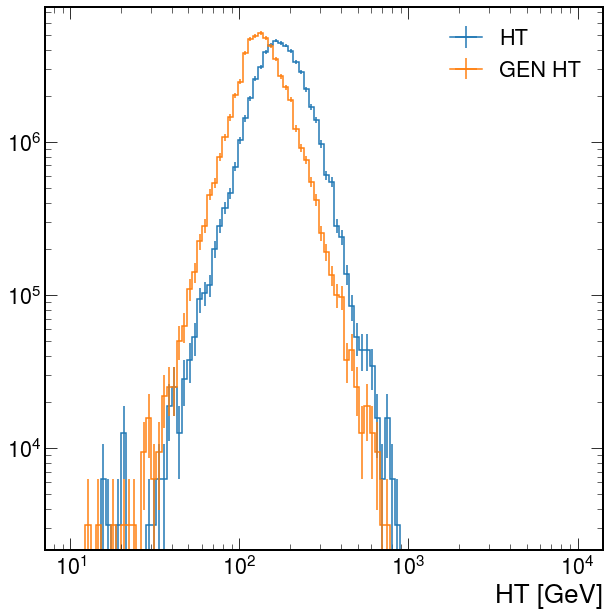

In [25]:
(
    Hist.new.Reg(100, 10, 1e4, name="HT", label="HT [GeV]", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.sum(jets_DYJ1.pt, axis=-1),
        weight=weights_DYJ1
    )
    .plot(label="HT")
)
(
    Hist.new.Reg(100, 10, 1e4, name="HT", label="HT [GeV]", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.sum(genJets_DYJ1.pt, axis=-1),
        weight=weights_DYJ1
    )
    .plot(label="GEN HT")
)
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [48]:
print(weights_DYJ1)

[3.11e+03, 3.11e+03, 3.11e+03, 3.11e+03, ... 3.11e+03, 3.11e+03, 3.11e+03, 3.11e+03]


(100.0, 10000000000.0)

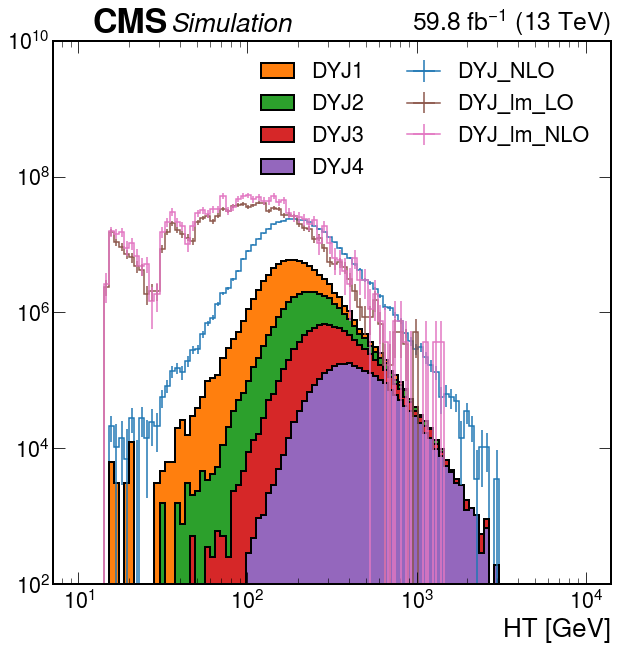

In [27]:
(
    Hist.new.Reg(100, 10, 1e4, name="HT", label="HT [GeV]", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.sum(jets_DYJ_NLO.pt, axis=-1),
        weight=weights_DYJ_NLO
    )
    .plot(label="DYJ_NLO")
)
h_DYJ1 = (
    Hist.new.Reg(100, 10, 1e4, name="HT", label="DYJ1", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.sum(jets_DYJ1.pt, axis=-1),
        weight=weights_DYJ1
    )
)
h_DYJ2 = (
    Hist.new.Reg(100, 10, 1e4, name="HT", label="DYJ2", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.sum(jets_DYJ2.pt, axis=-1),
        weight=weights_DYJ2
    )
)
h_DYJ3 = (
    Hist.new.Reg(100, 10, 1e4, name="HT", label="DYJ3", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.sum(jets_DYJ3.pt, axis=-1),
        weight=weights_DYJ3
    )
)
h_DYJ4 = (
    Hist.new.Reg(100, 10, 1e4, name="HT", label="DYJ4", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.sum(jets_DYJ4.pt, axis=-1),
        weight=weights_DYJ4
    )
)

list_plots = [h_DYJ1, h_DYJ2, h_DYJ3, h_DYJ4]

hep.histplot(
    list_plots[::-1],
    label=[h.axes[0].label for h in list_plots[::-1]],
    stack=True,
    histtype="fill",
    ec="black",
    lw=2,
)

(
    Hist.new.Reg(100, 10, 1e4, name="HT", label="HT [GeV]", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.sum(jets_DYJ_lm_LO.pt, axis=-1),
        weight=weights_DYJ_lm_LO
    )
    .plot(label="DYJ_lm_LO")
)
(
    Hist.new.Reg(100, 10, 1e4, name="HT", label="HT [GeV]", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.sum(jets_DYJ_lm_NLO.pt, axis=-1),
        weight=weights_DYJ_lm_NLO
    )
    .plot(label="DYJ_lm_NLO")
)
hep.cms.label(llabel="Simulation", data=False, lumi=r"59.8")
plt.legend(ncol=2)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e2, 1e10)

(100.0, 10000000000.0)

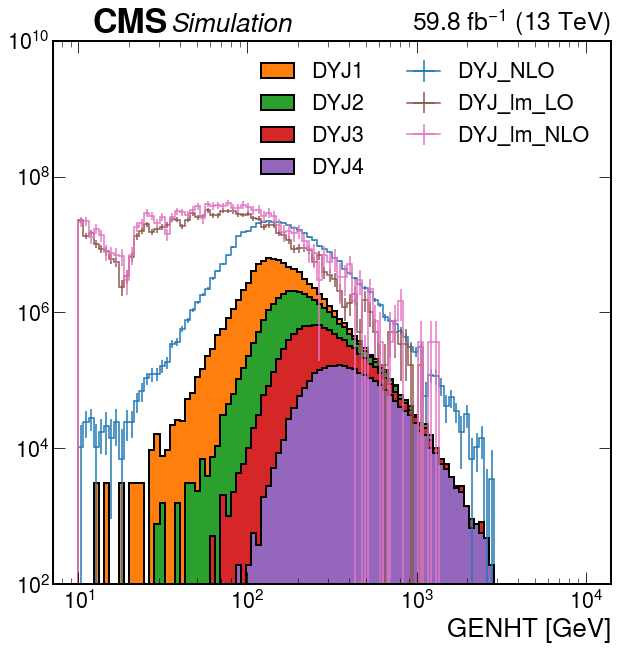

In [28]:
(
    Hist.new.Reg(100, 10, 1e4, name="GENHT", label="GENHT [GeV]", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.sum(genJets_DYJ_NLO.pt, axis=-1),
        weight=weights_DYJ_NLO
    )
    .plot(label="DYJ_NLO")
)
h_DYJ1 = (
    Hist.new.Reg(100, 10, 1e4, name="GENHT", label="DYJ1", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.sum(genJets_DYJ1.pt, axis=-1),
        weight=weights_DYJ1
    )
)
h_DYJ2 = (
    Hist.new.Reg(100, 10, 1e4, name="GENHT", label="DYJ2", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.sum(genJets_DYJ2.pt, axis=-1),
        weight=weights_DYJ2
    )
)
h_DYJ3 = (
    Hist.new.Reg(100, 10, 1e4, name="GENHT", label="DYJ3", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.sum(genJets_DYJ3.pt, axis=-1),
        weight=weights_DYJ3
    )
)
h_DYJ4 = (
    Hist.new.Reg(100, 10, 1e4, name="GENHT", label="DYJ4", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.sum(genJets_DYJ4.pt, axis=-1),
        weight=weights_DYJ4
    )
)

list_plots = [h_DYJ1, h_DYJ2, h_DYJ3, h_DYJ4]

hep.histplot(
    list_plots[::-1],
    label=[h.axes[0].label for h in list_plots[::-1]],
    stack=True,
    histtype="fill",
    ec="black",
    lw=2,
)

(
    Hist.new.Reg(100, 10, 1e4, name="GENHT", label="GENHT [GeV]", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.sum(genJets_DYJ_lm_LO.pt, axis=-1),
        weight=weights_DYJ_lm_LO
    )
    .plot(label="DYJ_lm_LO")
)
(
    Hist.new.Reg(100, 10, 1e4, name="GENHT", label="GENHT [GeV]", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.sum(genJets_DYJ_lm_NLO.pt, axis=-1),
        weight=weights_DYJ_lm_NLO
    )
    .plot(label="DYJ_lm_NLO")
)
hep.cms.label(llabel="Simulation", data=False, lumi=r"59.8")
plt.legend(ncol=2)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e2, 1e10)

(1000.0, 10000000000.0)

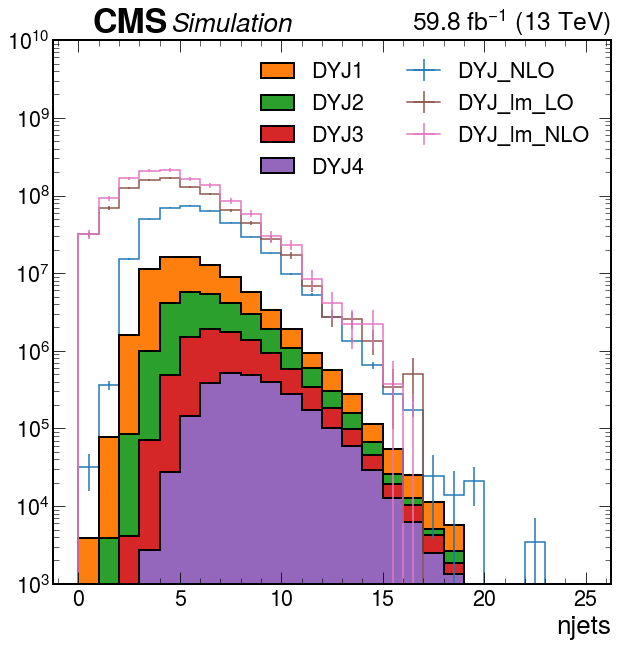

In [33]:
(
    Hist.new.Reg(25, 0, 25, name="njets", label="njets")
    .Weight()
    .fill(
        ak.num(jets_DYJ_NLO),
        weight=weights_DYJ_NLO
    )
    .plot(label="DYJ_NLO")
)
h_DYJ1 = (
    Hist.new.Reg(25, 0, 25, name="njets", label="DYJ1")
    .Weight()
    .fill(
        ak.num(jets_DYJ1),
        weight=weights_DYJ1
    )
)
h_DYJ2 = (
    Hist.new.Reg(25, 0, 25, name="njets", label="DYJ2")
    .Weight()
    .fill(
        ak.num(jets_DYJ2),
        weight=weights_DYJ2
    )
)
h_DYJ3 = (
    Hist.new.Reg(25, 0, 25, name="njets", label="DYJ3")
    .Weight()
    .fill(
        ak.num(jets_DYJ3),
        weight=weights_DYJ3
    )
)
h_DYJ4 = (
    Hist.new.Reg(25, 0, 25, name="njets", label="DYJ4")
    .Weight()
    .fill(
        ak.num(jets_DYJ4),
        weight=weights_DYJ4
    )
)

list_plots = [h_DYJ1, h_DYJ2, h_DYJ3, h_DYJ4]

hep.histplot(
    list_plots[::-1],
    label=[h.axes[0].label for h in list_plots[::-1]],
    stack=True,
    histtype="fill",
    ec="black",
    lw=2,
)

(
    Hist.new.Reg(25, 0, 25, name="njets", label="njets")
    .Weight()
    .fill(
        ak.num(jets_DYJ_lm_LO),
        weight=weights_DYJ_lm_LO
    )
    .plot(label="DYJ_lm_LO")
)
(
    Hist.new.Reg(25, 0, 25, name="njets", label="njets")
    .Weight()
    .fill(
        ak.num(jets_DYJ_lm_NLO),
        weight=weights_DYJ_lm_NLO
    )
    .plot(label="DYJ_lm_NLO")
)
hep.cms.label(llabel="Simulation", data=False, lumi=r"59.8")
plt.legend(ncol=2)
plt.yscale('log')
plt.ylim(1e3, 1e10)

(1000.0, 10000000000.0)

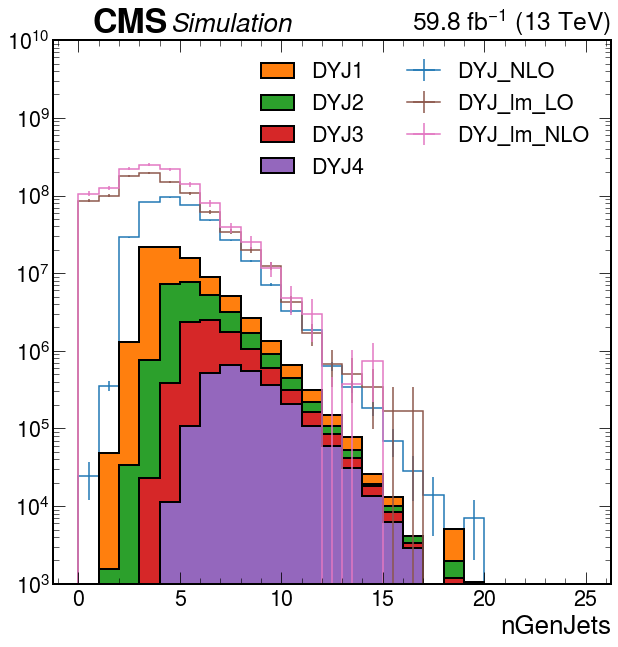

In [34]:
(
    Hist.new.Reg(25, 0, 25, name="nGenJets", label="nGenJets")
    .Weight()
    .fill(
        ak.num(genJets_DYJ_NLO),
        weight=weights_DYJ_NLO
    )
    .plot(label="DYJ_NLO")
)
h_DYJ1 = (
    Hist.new.Reg(25, 0, 25, name="nGenJets", label="DYJ1")
    .Weight()
    .fill(
        ak.num(genJets_DYJ1),
        weight=weights_DYJ1
    )
)
h_DYJ2 = (
    Hist.new.Reg(25, 0, 25, name="nGenJets", label="DYJ2")
    .Weight()
    .fill(
        ak.num(genJets_DYJ2),
        weight=weights_DYJ2
    )
)
h_DYJ3 = (
    Hist.new.Reg(25, 0, 25, name="nGenJets", label="DYJ3")
    .Weight()
    .fill(
        ak.num(genJets_DYJ3),
        weight=weights_DYJ3
    )
)
h_DYJ4 = (
    Hist.new.Reg(25, 0, 25, name="nGenJets", label="DYJ4")
    .Weight()
    .fill(
        ak.num(genJets_DYJ4),
        weight=weights_DYJ4
    )
)

list_plots = [h_DYJ1, h_DYJ2, h_DYJ3, h_DYJ4]

hep.histplot(
    list_plots[::-1],
    label=[h.axes[0].label for h in list_plots[::-1]],
    stack=True,
    histtype="fill",
    ec="black",
    lw=2,
)

(
    Hist.new.Reg(25, 0, 25, name="nGenJets", label="nGenJets")
    .Weight()
    .fill(
        ak.num(genJets_DYJ_lm_LO),
        weight=weights_DYJ_lm_LO
    )
    .plot(label="DYJ_lm_LO")
)
(
    Hist.new.Reg(25, 0, 25, name="nGenJets", label="nGenJets")
    .Weight()
    .fill(
        ak.num(genJets_DYJ_lm_NLO),
        weight=weights_DYJ_lm_NLO
    )
    .plot(label="DYJ_lm_NLO")
)
hep.cms.label(llabel="Simulation", data=False, lumi=r"59.8")
plt.legend(ncol=2)
plt.yscale('log')
plt.ylim(1e3, 1e10)

(1000.0, 10000000000.0)

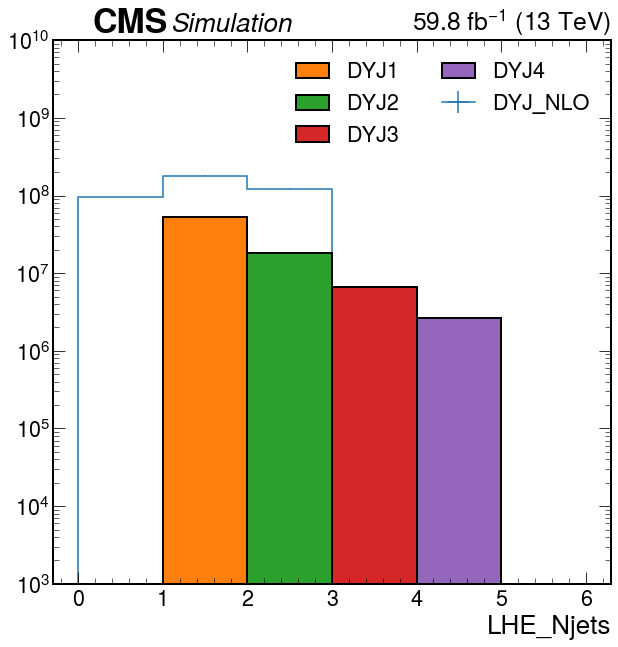

In [26]:
nBins = 6
(
    Hist.new.Reg(nBins, 0, nBins, name="LHE_Njets", label="LHE_Njets")
    .Weight()
    .fill(
        LHE_DYJ_NLO.Njets,
        weight=weights_DYJ_NLO
    )
    .plot(label="DYJ_NLO")
)
h_DYJ1 = (
    Hist.new.Reg(nBins, 0, nBins, name="LHE_Njets", label="DYJ1")
    .Weight()
    .fill(
        LHE_DYJ1.Njets,
        weight=weights_DYJ1
    )
)
h_DYJ2 = (
    Hist.new.Reg(nBins, 0, nBins, name="LHE_Njets", label="DYJ2")
    .Weight()
    .fill(
        LHE_DYJ2.Njets,
        weight=weights_DYJ2
    )
)
h_DYJ3 = (
    Hist.new.Reg(nBins, 0, nBins, name="LHE_Njets", label="DYJ3")
    .Weight()
    .fill(
        LHE_DYJ3.Njets,
        weight=weights_DYJ3
    )
)
h_DYJ4 = (
    Hist.new.Reg(nBins, 0, nBins, name="LHE_Njets", label="DYJ4")
    .Weight()
    .fill(
        LHE_DYJ4.Njets,
        weight=weights_DYJ4
    )
)

list_plots = [h_DYJ1, h_DYJ2, h_DYJ3, h_DYJ4]

hep.histplot(
    list_plots[::-1],
    label=[h.axes[0].label for h in list_plots[::-1]],
    stack=True,
    histtype="fill",
    ec="black",
    lw=2,
)

# (
#     Hist.new.Reg(nBins, 0, nBins, name="LHE_Njets", label="LHE_Njets")
#     .Weight()
#     .fill(
#         LHE_DYJ_lm_LO.Njets,
#         weight=weights_DYJ_lm_LO
#     )
#     .plot(label="DYJ_lm_LO")
# )
# (
#     Hist.new.Reg(nBins, 0, nBins, name="LHE_Njets", label="LHE_Njets")
#     .Weight()
#     .fill(
#         LHE_DYJ_lm_NLO.Njets,
#         weight=weights_DYJ_lm_NLO
#     )
#     .plot(label="DYJ_lm_NLO")
# )
hep.cms.label(llabel="Simulation", data=False, lumi=r"59.8")
plt.legend(ncol=2)
plt.yscale('log')
plt.ylim(1e3, 1e10)

(1000.0, 10000000000.0)

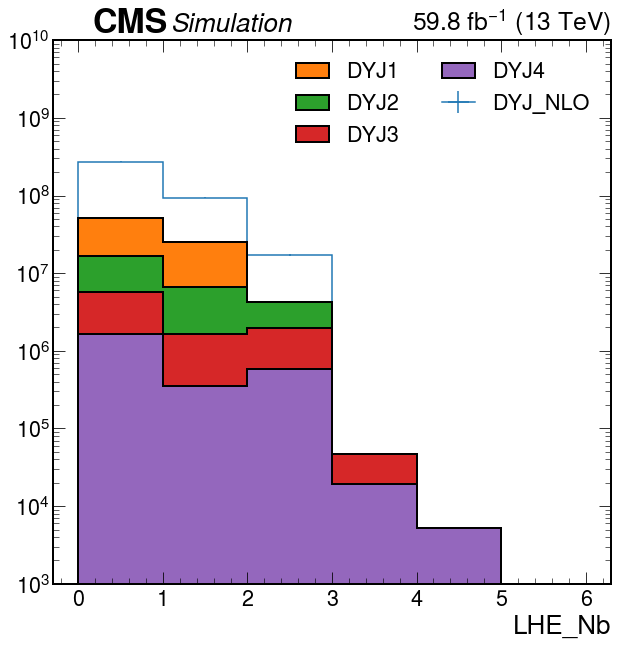

In [28]:
nBins = 6
(
    Hist.new.Reg(nBins, 0, nBins, name="LHE_Nb", label="LHE_Nb")
    .Weight()
    .fill(
        LHE_DYJ_NLO.Nb,
        weight=weights_DYJ_NLO
    )
    .plot(label="DYJ_NLO")
)
h_DYJ1 = (
    Hist.new.Reg(nBins, 0, nBins, name="LHE_Nb", label="DYJ1")
    .Weight()
    .fill(
        LHE_DYJ1.Nb,
        weight=weights_DYJ1
    )
)
h_DYJ2 = (
    Hist.new.Reg(nBins, 0, nBins, name="LHE_Nb", label="DYJ2")
    .Weight()
    .fill(
        LHE_DYJ2.Nb,
        weight=weights_DYJ2
    )
)
h_DYJ3 = (
    Hist.new.Reg(nBins, 0, nBins, name="LHE_Nb", label="DYJ3")
    .Weight()
    .fill(
        LHE_DYJ3.Nb,
        weight=weights_DYJ3
    )
)
h_DYJ4 = (
    Hist.new.Reg(nBins, 0, nBins, name="LHE_Nb", label="DYJ4")
    .Weight()
    .fill(
        LHE_DYJ4.Nb,
        weight=weights_DYJ4
    )
)

list_plots = [h_DYJ1, h_DYJ2, h_DYJ3, h_DYJ4]

hep.histplot(
    list_plots[::-1],
    label=[h.axes[0].label for h in list_plots[::-1]],
    stack=True,
    histtype="fill",
    ec="black",
    lw=2,
)

# (
#     Hist.new.Reg(nBins, 0, nBins, name="LHE_Nb", label="LHE_Nb")
#     .Weight()
#     .fill(
#         LHE_DYJ_lm_LO.Nb,
#         weight=weights_DYJ_lm_LO
#     )
#     .plot(label="DYJ_lm_LO")
# )
# (
#     Hist.new.Reg(nBins, 0, nBins, name="LHE_Nb", label="LHE_Nb")
#     .Weight()
#     .fill(
#         LHE_DYJ_lm_NLO.Nb,
#         weight=weights_DYJ_lm_NLO
#     )
#     .plot(label="DYJ_lm_NLO")
# )
hep.cms.label(llabel="Simulation", data=False, lumi=r"59.8")
plt.legend(ncol=2)
plt.yscale('log')
plt.ylim(1e3, 1e10)

Text(1, 0, 'nJets')

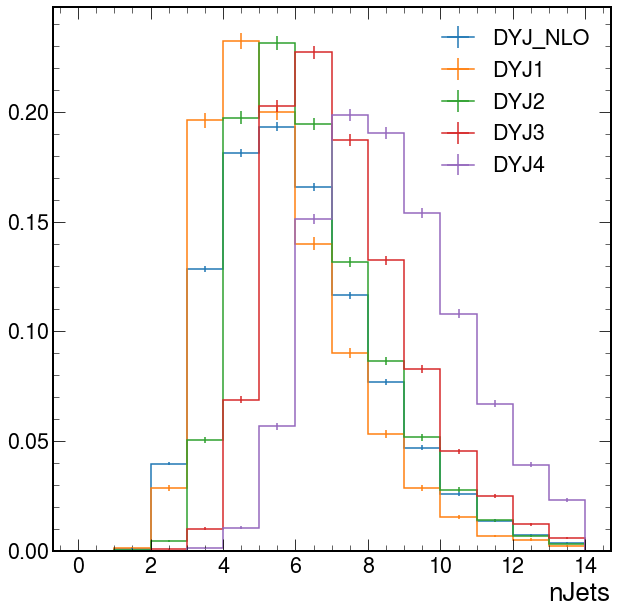

In [64]:
binning = (14, 0, 14)
h_DYJ_NLO = (
    Hist.new.Reg(*binning, name="nJets", label="DYJ_NLO")
    .Weight()
    .fill(
        ak.num(jets_DYJ_NLO),
        weight=weights_DYJ_NLO
    )
)
h_DYJ1 = (
    Hist.new.Reg(*binning, name="nJets", label="DYJ1")
    .Weight()
    .fill(
        ak.num(jets_DYJ1),
        weight=weights_DYJ1
    )
)
h_DYJ2 = (
    Hist.new.Reg(*binning, name="nJets", label="DYJ2")
    .Weight()
    .fill(
        ak.num(jets_DYJ2),
        weight=weights_DYJ2
    )
)
h_DYJ3 = (
    Hist.new.Reg(*binning, name="nJets", label="DYJ3")
    .Weight()
    .fill(
        ak.num(jets_DYJ3),
        weight=weights_DYJ3
    )
)
h_DYJ4 = (
    Hist.new.Reg(*binning, name="nJets", label="DYJ4")
    .Weight()
    .fill(
        ak.num(jets_DYJ4),
        weight=weights_DYJ4
    )
)

list_plots = [h_DYJ_NLO, h_DYJ1, h_DYJ2, h_DYJ3, h_DYJ4]

hep.histplot(
    list_plots,
    label=[h.axes[0].label for h in list_plots],
    density=True,
)

plt.legend()
plt.xlabel('nJets')

Text(1, 0, 'nGenJets')

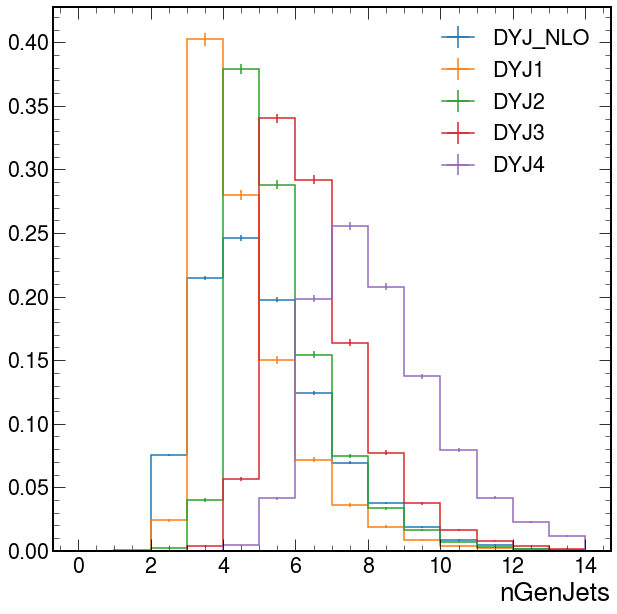

In [63]:
binning = (14, 0, 14)
h_DYJ_NLO = (
    Hist.new.Reg(*binning, name="nGenJets", label="DYJ_NLO")
    .Weight()
    .fill(
        ak.num(genJets_DYJ_NLO),
        weight=weights_DYJ_NLO
    )
)
h_DYJ1 = (
    Hist.new.Reg(*binning, name="nGenJets", label="DYJ1")
    .Weight()
    .fill(
        ak.num(genJets_DYJ1),
        weight=weights_DYJ1
    )
)
h_DYJ2 = (
    Hist.new.Reg(*binning, name="nGenJets", label="DYJ2")
    .Weight()
    .fill(
        ak.num(genJets_DYJ2),
        weight=weights_DYJ2
    )
)
h_DYJ3 = (
    Hist.new.Reg(*binning, name="nGenJets", label="DYJ3")
    .Weight()
    .fill(
        ak.num(genJets_DYJ3),
        weight=weights_DYJ3
    )
)
h_DYJ4 = (
    Hist.new.Reg(*binning, name="nGenJets", label="DYJ4")
    .Weight()
    .fill(
        ak.num(genJets_DYJ4),
        weight=weights_DYJ4
    )
)

list_plots = [h_DYJ_NLO, h_DYJ1, h_DYJ2, h_DYJ3, h_DYJ4]

hep.histplot(
    list_plots,
    label=[h.axes[0].label for h in list_plots],
    density=True,
)

plt.legend()
plt.xlabel('nGenJets')

(100000.0, 1000000000.0)

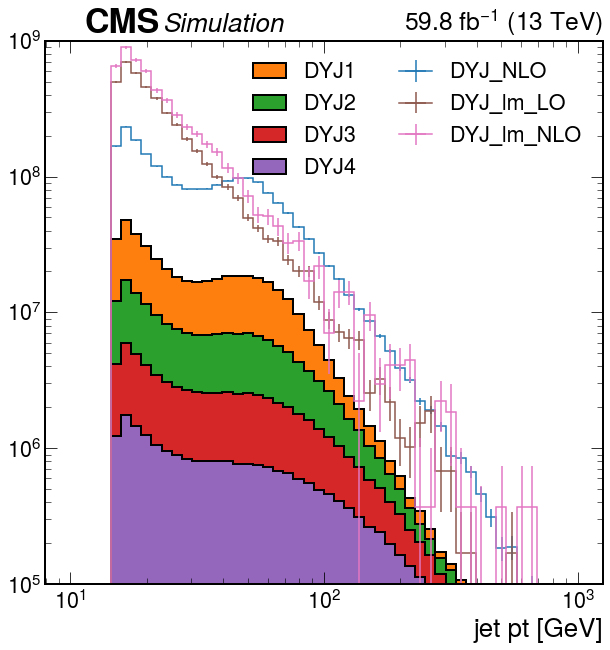

In [48]:
binning = (50, 10, 1000)
(
    Hist.new.Reg(*binning, name="jet pt", label="jet pt [GeV]", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.flatten(jets_DYJ_NLO.pt),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ_NLO, jets_DYJ_NLO.pt)[0])
    )
    .plot(label="DYJ_NLO")
)

h_DYJ1 = (
    Hist.new.Reg(*binning, name="jet pt", label="DYJ1", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.flatten(jets_DYJ1.pt),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ1, jets_DYJ1.pt)[0])
    )
)
h_DYJ2 = (
    Hist.new.Reg(*binning, name="jet pt", label="DYJ2", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.flatten(jets_DYJ2.pt),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ2, jets_DYJ2.pt)[0])
    )
)
h_DYJ3 = (
    Hist.new.Reg(*binning, name="jet pt", label="DYJ3", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.flatten(jets_DYJ3.pt),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ3, jets_DYJ3.pt)[0])
    )
)
h_DYJ4 = (
    Hist.new.Reg(*binning, name="jet pt", label="DYJ4", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.flatten(jets_DYJ4.pt),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ4, jets_DYJ4.pt)[0])
    )
)

list_plots = [h_DYJ1, h_DYJ2, h_DYJ3, h_DYJ4]

hep.histplot(
    list_plots[::-1],
    label=[h.axes[0].label for h in list_plots[::-1]],
    stack=True,
    histtype="fill",
    ec="black",
    lw=2,
)

(
    Hist.new.Reg(*binning, name="jet pt", label="jet pt [GeV]", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.flatten(jets_DYJ_lm_LO.pt),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ_lm_LO, jets_DYJ_lm_LO.pt)[0])
    )
    .plot(label="DYJ_lm_LO")
)
(
    Hist.new.Reg(*binning, name="jet pt", label="jet pt [GeV]", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.flatten(jets_DYJ_lm_NLO.pt),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ_lm_NLO, jets_DYJ_lm_NLO.pt)[0])
    )
    .plot(label="DYJ_lm_NLO")
)
hep.cms.label(llabel="Simulation", data=False, lumi=r"59.8")
plt.legend(ncol=2)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e5, 1e9)

(10000.0, 10000000000.0)

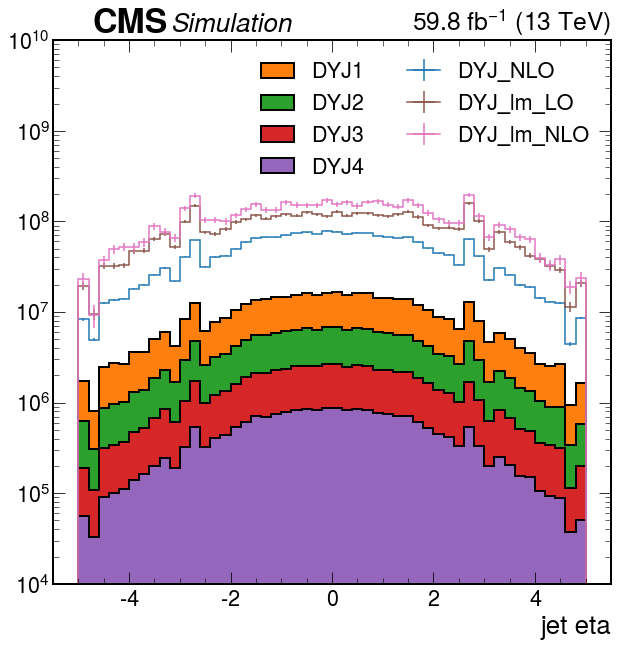

In [51]:
binning = (50, -5, 5)
(
    Hist.new.Reg(*binning, name="jet eta", label="jet eta")
    .Weight()
    .fill(
        ak.flatten(jets_DYJ_NLO.eta),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ_NLO, jets_DYJ_NLO.eta)[0])
    )
    .plot(label="DYJ_NLO")
)

h_DYJ1 = (
    Hist.new.Reg(*binning, name="jet eta", label="DYJ1")
    .Weight()
    .fill(
        ak.flatten(jets_DYJ1.eta),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ1, jets_DYJ1.eta)[0])
    )
)
h_DYJ2 = (
    Hist.new.Reg(*binning, name="jet eta", label="DYJ2")
    .Weight()
    .fill(
        ak.flatten(jets_DYJ2.eta),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ2, jets_DYJ2.eta)[0])
    )
)
h_DYJ3 = (
    Hist.new.Reg(*binning, name="jet eta", label="DYJ3")
    .Weight()
    .fill(
        ak.flatten(jets_DYJ3.eta),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ3, jets_DYJ3.eta)[0])
    )
)
h_DYJ4 = (
    Hist.new.Reg(*binning, name="jet eta", label="DYJ4")
    .Weight()
    .fill(
        ak.flatten(jets_DYJ4.eta),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ4, jets_DYJ4.eta)[0])
    )
)

list_plots = [h_DYJ1, h_DYJ2, h_DYJ3, h_DYJ4]

hep.histplot(
    list_plots[::-1],
    label=[h.axes[0].label for h in list_plots[::-1]],
    stack=True,
    histtype="fill",
    ec="black",
    lw=2,
)

(
    Hist.new.Reg(*binning, name="jet eta", label="jet eta")
    .Weight()
    .fill(
        ak.flatten(jets_DYJ_lm_LO.eta),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ_lm_LO, jets_DYJ_lm_LO.eta)[0])
    )
    .plot(label="DYJ_lm_LO")
)
(
    Hist.new.Reg(*binning, name="jet eta", label="jet eta")
    .Weight()
    .fill(
        ak.flatten(jets_DYJ_lm_NLO.eta),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ_lm_NLO, jets_DYJ_lm_NLO.eta)[0])
    )
    .plot(label="DYJ_lm_NLO")
)
hep.cms.label(llabel="Simulation", data=False, lumi=r"59.8")
plt.legend(ncol=2)
plt.yscale('log')
plt.ylim(1e4, 1e10)

In [52]:
muons_DYJ_NLO = get_muons('DYJ_NLO')
muons_DYJ1 = get_muons('DYJ1')
muons_DYJ2 = get_muons('DYJ2')
muons_DYJ3 = get_muons('DYJ3')
muons_DYJ4 = get_muons('DYJ4')
muons_DYJ_lm_LO = get_muons('DYJ_lm_LO')
muons_DYJ_lm_NLO = get_muons('DYJ_lm_NLO')

(100000.0, 1000000000.0)

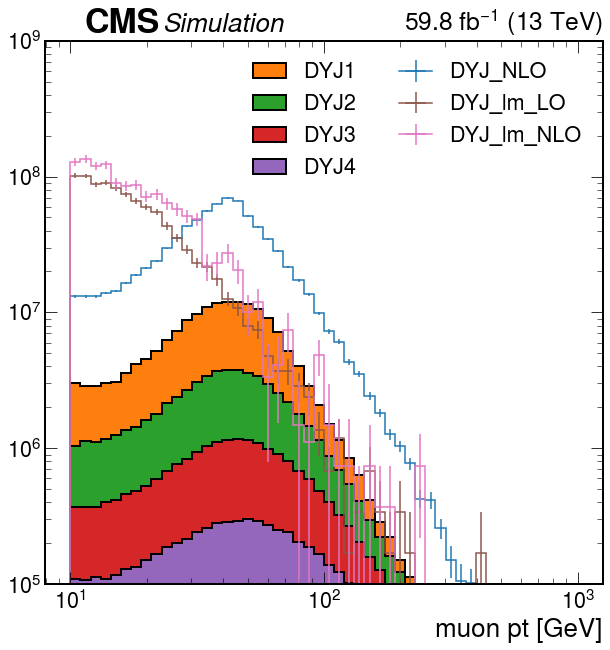

In [53]:
binning = (50, 10, 1000)
(
    Hist.new.Reg(*binning, name="muon pt", label="muon pt [GeV]", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.flatten(muons_DYJ_NLO.pt),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ_NLO, muons_DYJ_NLO.pt)[0])
    )
    .plot(label="DYJ_NLO")
)

h_DYJ1 = (
    Hist.new.Reg(*binning, name="muon pt", label="DYJ1", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.flatten(muons_DYJ1.pt),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ1, muons_DYJ1.pt)[0])
    )
)
h_DYJ2 = (
    Hist.new.Reg(*binning, name="muon pt", label="DYJ2", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.flatten(muons_DYJ2.pt),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ2, muons_DYJ2.pt)[0])
    )
)
h_DYJ3 = (
    Hist.new.Reg(*binning, name="muon pt", label="DYJ3", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.flatten(muons_DYJ3.pt),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ3, muons_DYJ3.pt)[0])
    )
)
h_DYJ4 = (
    Hist.new.Reg(*binning, name="muon pt", label="DYJ4", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.flatten(muons_DYJ4.pt),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ4, muons_DYJ4.pt)[0])
    )
)

list_plots = [h_DYJ1, h_DYJ2, h_DYJ3, h_DYJ4]

hep.histplot(
    list_plots[::-1],
    label=[h.axes[0].label for h in list_plots[::-1]],
    stack=True,
    histtype="fill",
    ec="black",
    lw=2,
)

(
    Hist.new.Reg(*binning, name="muon pt", label="muon pt [GeV]", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.flatten(muons_DYJ_lm_LO.pt),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ_lm_LO, muons_DYJ_lm_LO.pt)[0])
    )
    .plot(label="DYJ_lm_LO")
)
(
    Hist.new.Reg(*binning, name="muon pt", label="muon pt [GeV]", transform=hist.axis.transform.log)
    .Weight()
    .fill(
        ak.flatten(muons_DYJ_lm_NLO.pt),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ_lm_NLO, muons_DYJ_lm_NLO.pt)[0])
    )
    .plot(label="DYJ_lm_NLO")
)
hep.cms.label(llabel="Simulation", data=False, lumi=r"59.8")
plt.legend(ncol=2)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e5, 1e9)

(10000.0, 10000000000.0)

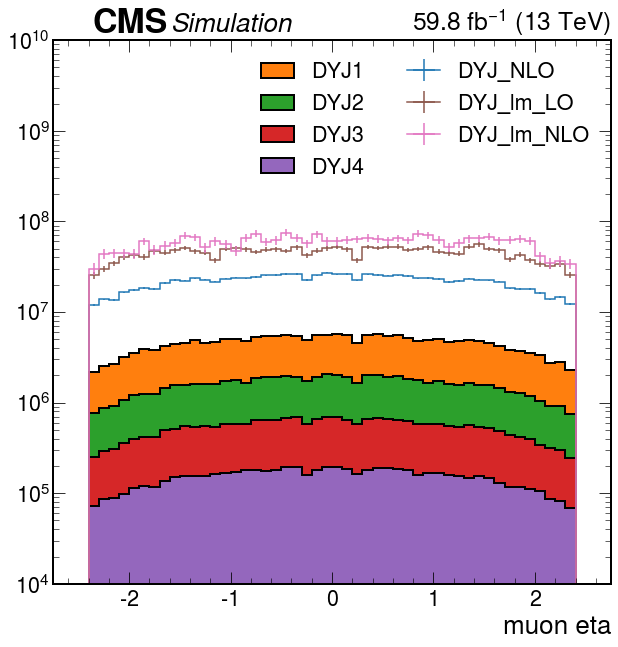

In [55]:
binning = (50, -2.5, 2.5)
(
    Hist.new.Reg(*binning, name="muon eta", label="muon eta")
    .Weight()
    .fill(
        ak.flatten(muons_DYJ_NLO.eta),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ_NLO, muons_DYJ_NLO.eta)[0])
    )
    .plot(label="DYJ_NLO")
)

h_DYJ1 = (
    Hist.new.Reg(*binning, name="muon eta", label="DYJ1")
    .Weight()
    .fill(
        ak.flatten(muons_DYJ1.eta),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ1, muons_DYJ1.eta)[0])
    )
)
h_DYJ2 = (
    Hist.new.Reg(*binning, name="muon eta", label="DYJ2")
    .Weight()
    .fill(
        ak.flatten(muons_DYJ2.eta),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ2, muons_DYJ2.eta)[0])
    )
)
h_DYJ3 = (
    Hist.new.Reg(*binning, name="muon eta", label="DYJ3")
    .Weight()
    .fill(
        ak.flatten(muons_DYJ3.eta),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ3, muons_DYJ3.eta)[0])
    )
)
h_DYJ4 = (
    Hist.new.Reg(*binning, name="muon eta", label="DYJ4")
    .Weight()
    .fill(
        ak.flatten(muons_DYJ4.eta),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ4, muons_DYJ4.eta)[0])
    )
)

list_plots = [h_DYJ1, h_DYJ2, h_DYJ3, h_DYJ4]

hep.histplot(
    list_plots[::-1],
    label=[h.axes[0].label for h in list_plots[::-1]],
    stack=True,
    histtype="fill",
    ec="black",
    lw=2,
)

(
    Hist.new.Reg(*binning, name="muon eta", label="muon eta")
    .Weight()
    .fill(
        ak.flatten(muons_DYJ_lm_LO.eta),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ_lm_LO, muons_DYJ_lm_LO.eta)[0])
    )
    .plot(label="DYJ_lm_LO")
)
(
    Hist.new.Reg(*binning, name="muon eta", label="muon eta")
    .Weight()
    .fill(
        ak.flatten(muons_DYJ_lm_NLO.eta),
        weight=ak.flatten(ak.broadcast_arrays(weights_DYJ_lm_NLO, muons_DYJ_lm_NLO.eta)[0])
    )
    .plot(label="DYJ_lm_NLO")
)
hep.cms.label(llabel="Simulation", data=False, lumi=r"59.8")
plt.legend(ncol=2)
plt.yscale('log')
plt.ylim(1e4, 1e10)

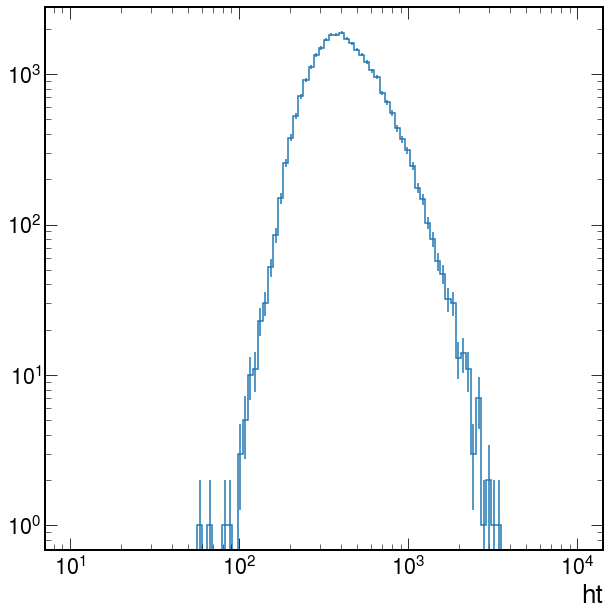

In [43]:
(
    Hist.new.Reg(100, 10, 1e4, name="ht", label="ht", transform=hist.axis.transform.log)
    .Double()
    .fill(
        ak.sum(events.Jet.pt, axis=-1)
    )
    .plot()
)
plt.xscale('log')
plt.yscale('log')

In [37]:
all_pairs = ak.combinations(muons, n=2,axis=-1) #, highlevel=True, with_name="Momentum4D")
mu1, mu2 = ak.unzip(all_pairs)
opposite_charges = mu1.charge != mu2.charge
mu1_os = mu1[opposite_charges]
mu2_os = mu2[opposite_charges]
os_pairs = mu1 + mu2

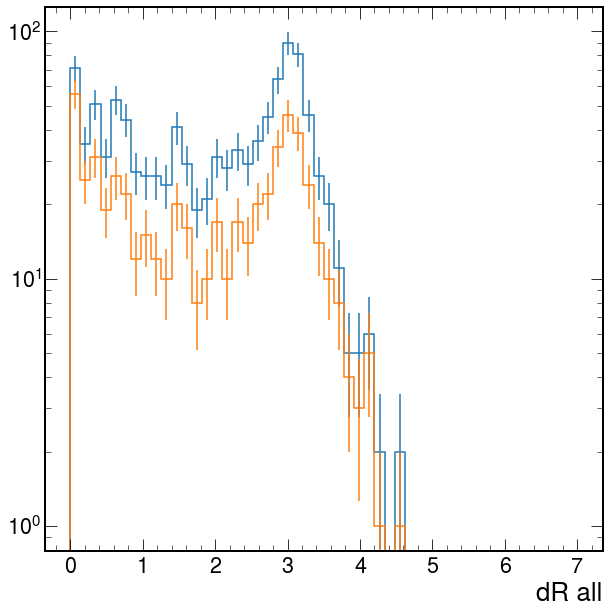

In [39]:
(
    Hist.new.Reg(50, 0, 7, name="dR all", label="dR all")
    .Double()
    .fill(
        ak.flatten(mu1.delta_r(mu2))
    )
    .plot()
)
(
    Hist.new.Reg(50, 0, 7, name="dR os", label="dR os")
    .Double()
    .fill(
        ak.flatten(mu1_os.delta_r(mu2_os))
    )
    .plot()
)
plt.yscale('log')

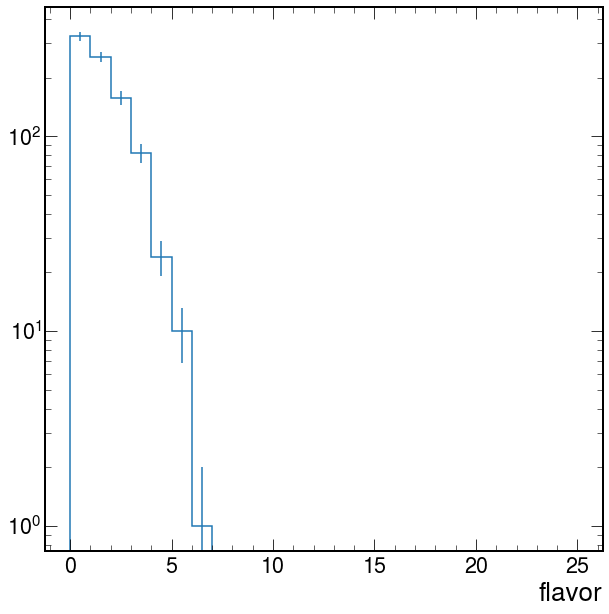

In [10]:
(
    Hist.new.Reg(25, 0, 25, name="flavor", label="flavor")
    .Double()
    .fill(
        ak.sum(abs(events.GenJet.partonFlavour) == 4, axis=1)
    )
    .plot()
)
plt.yscale('log')

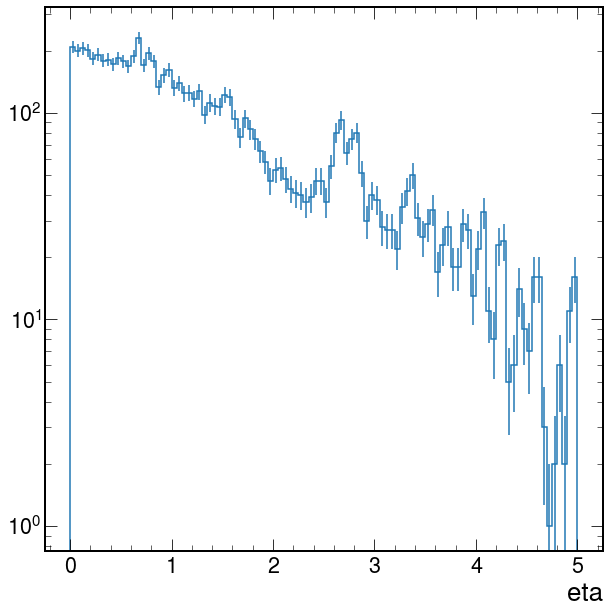

In [22]:
(
    Hist.new.Reg(100, 0, 5, name="eta", label="eta")
    .Double()
    .fill(
        ak.flatten(abs(events.Jet.eta))
    )
    .plot()
)
plt.yscale('log')

In [62]:
events.Muon.matched_jet

<Array [None, 26.5, 27.3, None] type='4 * ?float32[parameters={"__doc__": "pt"}]'>

In [11]:
events.Muon.dxy

<Array [[-0.0107, 0.0228, ... 0.0716, 0.0103]] type='2856 * var * float32[parame...'>

In [18]:
muon_test = events.Muon[events.Muon.pt > 50]

In [26]:
print(muon_test.pt)

[[162], [], [], [69.5], [107, 82.3, 58.6, ... [157, 115, 108], [], [88.2], [50.4]]


In [25]:
print(muon_test[:, :1].pt)

[[162], [], [], [69.5], [107], [84.6], ... [666], [], [157], [], [88.2], [50.4]]


In [28]:
ak.flatten(events.Muon.genPartFlav[:, :1]).to_numpy().astype(int)

array([5, 0, 0, ..., 0, 0, 5])

In [75]:
ak.sum(ak.num(muons) < 5)

2

In [10]:
muons = events.Muon[
    events.Muon.mediumId
    & (events.Muon.pt > 3)
    & (abs(events.Muon.dxy) <= 0.02)
    & (abs(events.Muon.dz) <= 0.1)
    & (abs(events.Muon.eta) < 2.4)
]
muons = muons[ak.num(muons) < 5]
muons_collection = ak.zip(
    {
        "pt": muons.pt,
        "eta": muons.eta,
        "phi": muons.phi,
        "mass": muons.mass,
        "charge": muons.pdgId / (-13),
    },
    with_name="Momentum4D",
)

In [15]:
clean_electrons = (
    (events.Electron.mvaFall17V2noIso_WPL)
    & (events.Electron.pt > 3)
    & (
        abs(events.Electron.dxy)
        < 0.05 + 0.05 * (abs(events.Electron.eta) > 1.479)
    )
    & (
        abs(events.Electron.dz)
        < 0.10 + 0.10 * (abs(events.Electron.eta) > 1.479)
    )
    & ((abs(events.Electron.eta) < 1.444) | (abs(events.Electron.eta) > 1.566))
    & (abs(events.Electron.eta) < 2.5)
)
electrons = events.Electron[clean_electrons]
electrons = electrons[ak.num(muons) < 5]
electrons_collection = ak.zip(
    {
        "pt": electrons.pt,
        "eta": electrons.eta,
        "phi": electrons.phi,
        "mass": electrons.mass,
        "charge": electrons.pdgId / (-11),
    },
    with_name="Momentum4D",
)

In [23]:
muons_collection

<MomentumArray4D [[], []] type='2 * var * Momentum4D["pt": float32[parameters={"...'>

In [17]:
ak.num(electrons_collection)

<Array [1, 3] type='2 * int64'>

In [18]:
electrons_collection

<MomentumArray4D [[{pt: 6.47, ... charge: -1}]] type='2 * var * Momentum4D["pt":...'>

In [31]:
empty_arr = ak.singletons(ak.Array([None] * len(muons_collection)))
empty_collection = ak.zip(
    {
        "pt": empty_arr,
        "eta": empty_arr,
        "phi": empty_arr,
        "mass": empty_arr,
        "charge": empty_arr,
    },
    with_name="Momentum4D",
)
electrons_collection = ak.where(
    ak.num(muons_collection) == 0,
    empty_collection,
    electrons_collection,
)

In [34]:
electrons_collection.pt

<Array [[], []] type='2 * var * float32[parameters={"__doc__": "p_{T}"}]'>

In [38]:
import sys

In [39]:
sys.path.append('../workflows')

In [40]:
import SUEP_utils

In [78]:
muons_genPartFlav = ak.flatten(ak.zeros_like(muons.pt, dtype=int))
print("muons_genPartFlav", len(muons_genPartFlav), muons_genPartFlav)
lmuons_genPartFlav = ak.flatten(ak.zeros_like(muons[:, :1].pt, dtype=int))
print("lmuons_genPartFlav", len(lmuons_genPartFlav), lmuons_genPartFlav)
lweights = np.ones_like(lmuons_genPartFlav)
print("lweights", len(lweights), lweights)
muons_genPartFlav = ak.flatten(muons.genPartFlav).to_numpy().astype(int)
print("muons_genPartFlav", len(muons_genPartFlav), muons_genPartFlav)
lmuons_genPartFlav = (
    ak.flatten(muons.genPartFlav[:, :1]).to_numpy().astype(int)
)
print("lmuons_genPartFlav", len(lmuons_genPartFlav), lmuons_genPartFlav)
lmuons = ak.num(muons)[ak.num(muons) > 0]
print("lmuons", len(lmuons), lmuons)

muons_genPartFlav 0 []
lmuons_genPartFlav 0 []
lweights 0 []
muons_genPartFlav 0 []
lmuons_genPartFlav 0 []
lmuons 0 []


In [82]:
leading_muons = muons_collection[:, :1]
ak.flatten(SUEP_utils.inter_isolation(leading_muons, muons_collection, dR=1.6))

<Array [] type='0 * float32'>

In [65]:
muons = events.Muon[
    events.Muon.mediumId
    & (events.Muon.pt > 3)
    & (abs(events.Muon.dxy) <= 0.02)
    & (abs(events.Muon.dz) <= 0.1)
    & (abs(events.Muon.eta) < 2.4)
]

In [48]:
print(len(ak.flatten(events.Jet.btagDeepB)))
print(ak.sum(ak.flatten(events.Jet.btagDeepB > 0.1208)))
print(ak.sum(ak.flatten(events.Jet.btagDeepB > 0.1208)) / len(ak.flatten(events.Jet.btagDeepB)))

70142
21717
0.30961478144335774


In [66]:
print(len(ak.flatten(muons.matched_jet.btagDeepB)))
print(ak.sum(ak.flatten(muons.matched_jet.btagDeepB > 0.1208)))
print(
    ak.sum(ak.flatten(muons.matched_jet.btagDeepB > 0.1208)) / 
    len(ak.flatten(muons.matched_jet.btagDeepB))
)

29079
9650
0.33185460297809416


In [49]:
print(len(ak.flatten(events.Jet.btagDeepFlavB)))
print(ak.sum(ak.flatten(events.Jet.btagDeepFlavB > 0.0490)))
print(ak.sum(ak.flatten(events.Jet.btagDeepFlavB > 0.0490)) / len(ak.flatten(events.Jet.btagDeepFlavB)))

70142
39612
0.56474009865701


In [68]:
print(len(ak.flatten(muons.matched_jet.btagDeepFlavB)))
print(ak.sum(ak.flatten(muons.matched_jet.btagDeepFlavB > 0.0490)))
print(ak.sum(ak.flatten(muons.matched_jet.btagDeepFlavB > 0.0490)) / len(ak.flatten(muons.matched_jet.btagDeepFlavB)))

29079
10626
0.36541834313422056


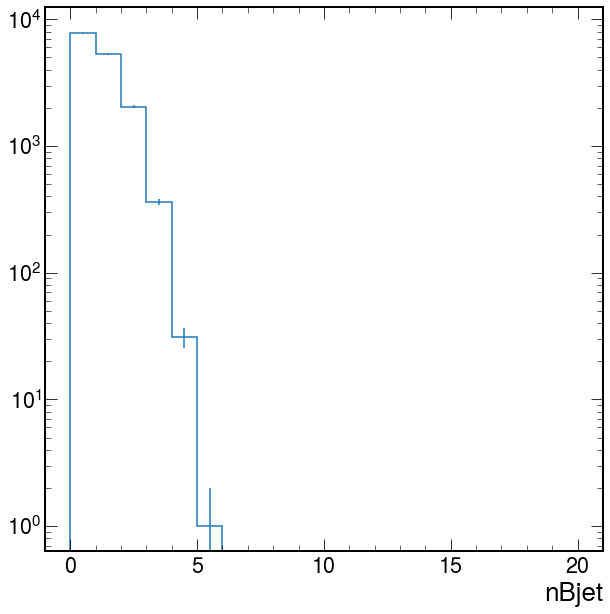

In [95]:
(
    Hist.new.Reg(20, 0, 20, name="nBjet", label="nBjet")
    .Double()
    .fill(
        ak.sum(muons.matched_jet.btagDeepFlavB > 0.0490, axis=1)
    )
    .plot()
)
plt.yscale('log')

In [96]:
muons.matched_jet.btagDeepFlavB

<Array [[0.0693], [0.0255, ... [None, 0.29]] type='15620 * var * ?float32[parame...'>

In [69]:
muons.jetNDauCharged

<Array [[2], [3], [1, 2, ... 2, 3], [], [1, 2]] type='15620 * var * uint8[parame...'>

In [70]:
muons.jetPtRelv2

<Array [[1.82], [0.49], ... [], [2.24, 1.45]] type='15620 * var * float32[parame...'>

In [71]:
muons.jetRelIso

<Array [[0.557], [4.47], ... [], [0.399, 2.47]] type='15620 * var * float32[para...'>

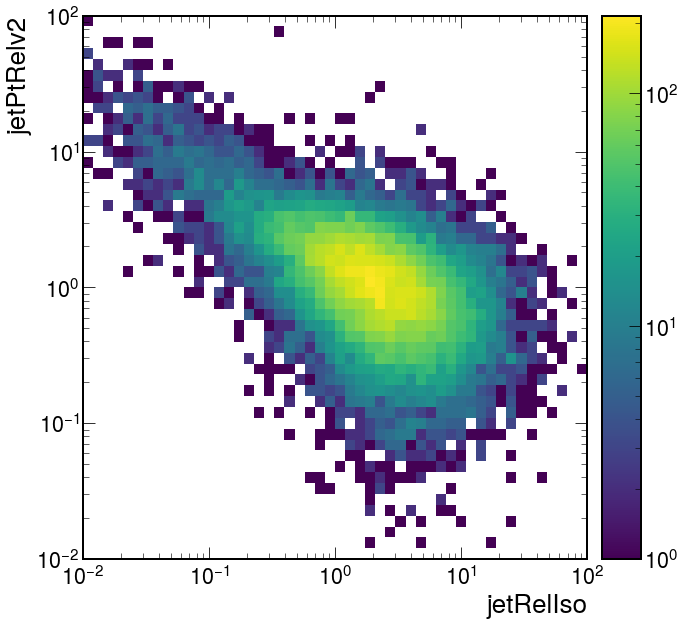

In [99]:
(
    Hist.new.Reg(50, 1e-2, 1e2, name="jetRelIso", label="jetRelIso", transform=hist.axis.transform.log)
    .Reg(50, 1e-2, 1e2, name="jetPtRelv2", label="jetPtRelv2", transform=hist.axis.transform.log)
    .Double()
    .fill(
        ak.fill_none(ak.flatten(muons.jetRelIso), 0), 
        ak.fill_none(ak.flatten(muons.jetPtRelv2), 0)
    )
    .plot(norm=matplotlib.colors.LogNorm(),)
)
plt.xscale('log')
plt.yscale('log')

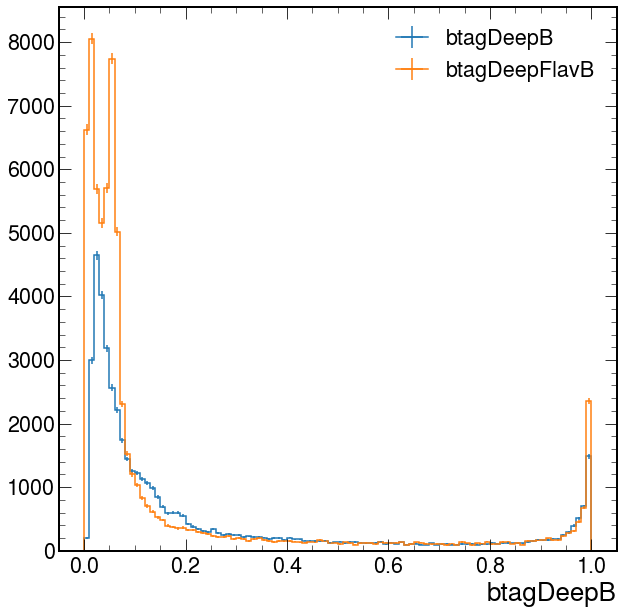

In [34]:
(
    Hist.new.Reg(100, 0, 1, name="btagDeepB", label="btagDeepB")
    .Double()
    .fill(ak.flatten(events.Jet.btagDeepB))
    .plot(label="btagDeepB")
)
(
    Hist.new.Reg(100, 0, 1, name="btagDeepFlavB", label="btagDeepFlavB")
    .Double()
    .fill(ak.flatten(events.Jet.btagDeepFlavB))
    .plot(label="btagDeepFlavB")
)
plt.legend();

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f7cd64153d0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f7cd6415610>, text=[])

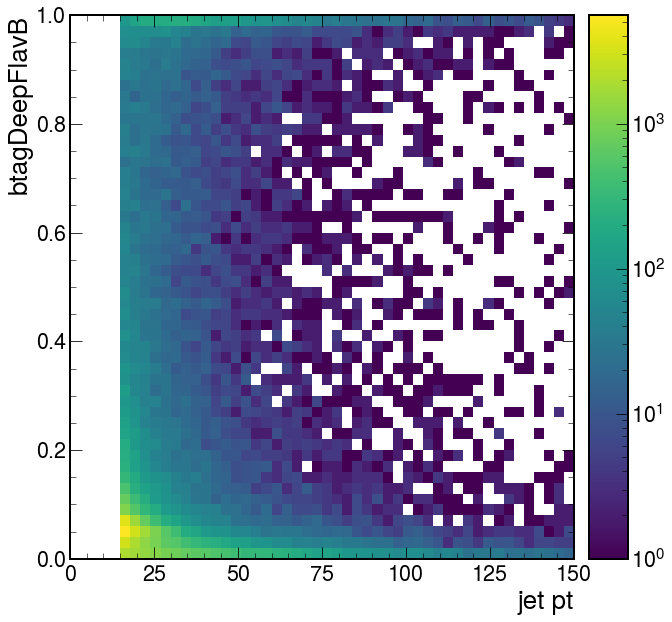

In [41]:
(
    Hist.new.Reg(50, 0, 150, name="jet pt", label="jet pt")
    .Reg(50, 0, 1, name="btagDeepFlavB", label="btagDeepFlavB")
    .Double()
    .fill(ak.flatten(events.Jet.pt), ak.flatten(events.Jet.btagDeepFlavB))
    .plot(norm=matplotlib.colors.LogNorm(),)
)

In [18]:
file = nanoevents.NanoEventsFactory.from_root(
    "root://xrootd.cmsaf.mit.edu//store/user/paus/nanosu/A02/DoubleMuon+Run2018A-UL2018_MiniAODv2-v1+MINIAOD/0FF8C48E-4C1A-4C41-8091-8B7AE7E1B035.root",
    schemaclass=nanoevents.NanoAODSchema)
events = file.events()

In [36]:
try:
    trigger = events.HLT.TripleMu_5_3_3_Mass3p8_DZ == 1
    print("haha")
except:
    print("This file seems to have the 2017 trigger names")
    trigger = events.HLT.TripleMu_5_3_3_Mass3p8to60_DZ == 1
    print("oops")

This file seems to have the 2017 trigger names
oops


In [24]:
for i, c in enumerate(events):
    print(c)
    if i > 5:
        break

<event 315361:166:137026666>
<event 315361:166:136247338>
<event 315361:166:137010539>
<event 315361:166:136961004>
<event 315361:166:136358503>
<event 315361:166:136879046>
<event 315361:166:136985773>


In [9]:
print(cutflow[0])
print(cutflow[1])
print(f"ratio: {cutflow[1].value / cutflow[0].value:0.5f}")

WeightedSum(value=2.97126e+09, variance=1.77844e+14)
WeightedSum(value=766079, variance=5.48293e+10)
ratio: 0.00026


In [10]:
len(events

27

In [57]:
events = events[:] 

In [58]:
muons = events.Muon[
    events.Muon.mediumId
    & (events.Muon.pt > 3)
    & (abs(events.Muon.dxy) <= 0.02)
    & (abs(events.Muon.dz) <= 0.1)
    & (abs(events.Muon.eta) < 2.4)
]
genMuons = events.GenPart[muons.genPartIdx]

In [69]:
def probabilistic_removal(muons_genPartFlav):
    """Will return a mask that will remove 7.2% of muons with flavor 0"""
    not_unmatched_muons = muons_genPartFlav != 0
    rng = np.random.default_rng(12345)
    counts = ak.num(muons_genPartFlav)
    numbers = rng.random(len(ak.flatten(muons_genPartFlav)))
    probs = ak.unflatten(numbers, counts)
    unmatched_muons_passing = probs > 0.072
    return not_unmatched_muons | unmatched_muons_passing

def LLP_free_muons(events, muons):
    """Will return a mask that will remove the non-0 muons that have an LLP in their gen history"""
    genParts = events.GenPart[muons.genPartIdx]
    is_unmatched = (muons.genPartFlav == 0)
    temp_parents = genParts
    has_matched = ak.full_like(temp_parents.pt, False, dtype=bool)
    while not ak.all(ak.is_none(temp_parents.pt, axis=-1)):
        mask = ak.fill_none(
            (abs(temp_parents.pdgId) == 130)
            | (abs(temp_parents.pdgId) == 211)
            | (abs(temp_parents.pdgId) == 321),
            False,
        )
        has_matched = ak.where(
            mask, ak.full_like(temp_parents.pt, True, dtype=bool), has_matched
        )
        temp_parents = temp_parents.parent
    return ~has_matched | is_unmatched

In [76]:
is_matched_LLP_free = LLP_free_muons(events, muons)
is_unmatched_LLP_free = probabilistic_removal(muons.genPartFlav)

In [77]:
print(muons.genPartFlav[-4:])

[[5, 4, 0], [4, 0], [5, 5], [5, 5]]


In [78]:
print(muons.genPartIdx[-4:])

[[133, 90, -1], [64, -1], [142, 179], [122, 102]]


In [93]:
print(ak.num(muons[-10:],axis=-1))

[5, 2, 2, 2, 1, 3, 3, 2, 2, 2]


In [92]:
print("These particles are NOT coming from an LLP:")
print(is_matched_LLP_free[-4:])
print(ak.sum(is_matched_LLP_free[-10:],axis=-1))

These particles are NOT coming from an LLP:
[[True, True, True], [True, True], [True, True], [True, True]]
[5, 1, 2, 2, 0, 3, 3, 2, 2, 2]


In [91]:
print("These particles have NOT been removed probabilistically:")
print(is_unmatched_LLP_free[-4:])
print(ak.sum(is_unmatched_LLP_free[-10:],axis=-1))

These particles have NOT been removed probabilistically:
[[True, True, False], [True, True], [True, True], [True, True]]
[5, 2, 2, 2, 1, 2, 2, 2, 2, 2]


In [90]:
print((is_matched_LLP_free & is_unmatched_LLP_free)[-4:])
print(ak.sum((is_matched_LLP_free & is_unmatched_LLP_free)[-10:],axis=-1))

[[True, True, False], [True, True], [True, True], [True, True]]
[5, 1, 2, 2, 0, 2, 2, 2, 2, 2]


In [82]:
unmatched_genParts = genMuons[muons.genPartFlav == 0]

In [53]:
unmatched_genParts.pdgId

<Array [[22], [-14], [14], ... [22], [22], []] type='2856 * var * int32[paramete...'>

In [52]:
muons.genPartIdx[muons.genPartFlav==0]

<Array [[-1], [-1], [-1], ... [-1], [-1], []] type='2856 * var * int32[parameter...'>

In [61]:
ak.sum(ak.flatten(~is_unmatched_with_LLP), axis=0)

2

In [74]:
ak.sum(~is_unmatched_with_LLP, axis=-1)

<Array [0, 0, 0, 0, 0, 0, ... 0, 1, 1, 0, 0, 0] type='30 * int64'>

In [62]:
events.Muon.genPartFlav

<Array [[0, 4, 4, 0], ... 0, 0, 0, 0, 5, 5]] type='30 * var * uint8[parameters={...'>

In [63]:
ak.sum(ak.flatten(has_LLP), axis=0)

8

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff53c01b8e0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

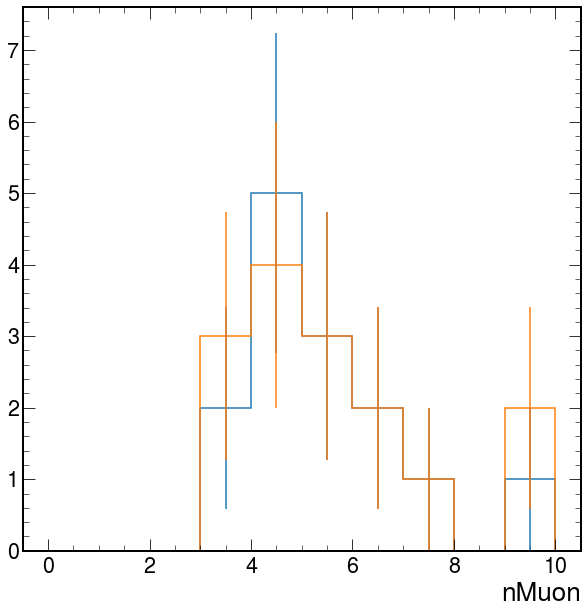

In [25]:
(
    Hist.new.Reg(10, 0, 10, name="nMuon", label="nMuon")
    .Double()
    .fill(ak.num(events.Muon.genPartFlav))
    .plot()
)
(
    Hist.new.Reg(10, 0, 10, name="nMuon", label="nMuon")
    .Double()
    .fill(ak.sum(probabilistic_removal(events.Muon.genPartFlav), axis=-1))
    .plot()
)

In [10]:
finalGenMuons = genMuons[genMuons.status == 1]

In [11]:
ak.is_none(finalGenMuons.parent.parent.parent.parent.parent.parent.parent.parent.pt, axis=-1)

<Array [[], [], [], [], ... [], [], [], []] type='2856 * var * bool'>

In [12]:
def gen_check(genParts):
    temp_parents = genParts
    has_matched = ak.full_like(temp_parents.pt, False, dtype=bool)
    while not ak.all(ak.is_none(temp_parents.pt, axis=-1)):
        mask = ak.fill_none(
            (abs(temp_parents.pdgId) == 130)
            | (abs(temp_parents.pdgId) == 211)
            | (abs(temp_parents.pdgId) == 321),
            False,
        )
        has_matched = ak.where(mask, ak.full_like(temp_parents.pt, True, dtype=bool), has_matched)
        temp_parents = temp_parents.parent
    return has_matched

In [13]:
ak.where(ak.Array([[None, 1],[None, 0]]) == 1, "haha", "nono")

<Array [[None, 'haha'], [None, 'nono']] type='2 * var * option[string]'>

In [14]:
events.GenPart[~gen_check(events.GenPart)]

<GenParticleArray [[GenParticle, ... GenParticle]] type='2856 * var * ?genParticle'>

In [28]:
rng = np.random.default_rng(12345)
counts = ak.num(events.GenPart)
numbers = rng.random(len(ak.flatten(events.GenPart)))
genPart_prob = ak.unflatten(numbers, counts)

In [41]:
ak.num(events.GenPart[genPart_prob > 0.072], axis=1)

<Array [51, 96, 88, 79, ... 36, 98, 132, 69] type='2856 * int64'>

In [40]:
ak.num(events.GenPart.pt, axis=1)

<Array [53, 103, 94, 85, ... 38, 105, 141, 74] type='2856 * int64'>

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f10c6750e50>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

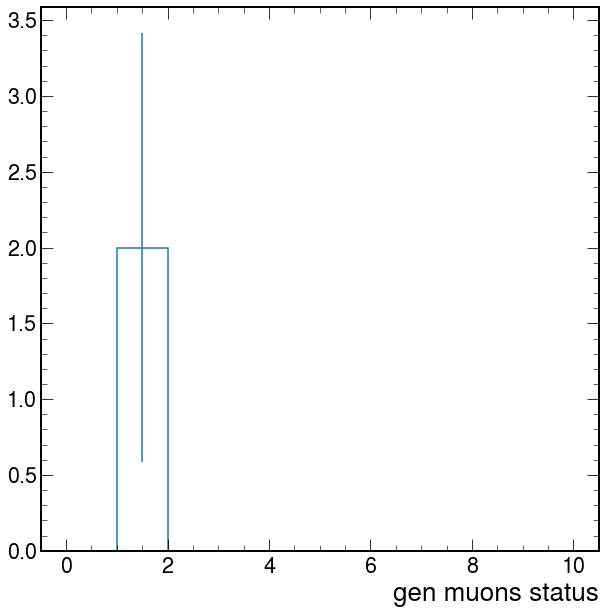

In [15]:
(
    Hist.new.Regular(10, 0, 10, name="gen muons status", label="gen muons status")
    .Double()
    .fill(ak.flatten(genMuons.status))
    .plot(label="gen muons")
)

In [ ]:
(
    Hist.new.Regular(50, 0, 10, name="gen muons pt", label="gen muons pt")
    .Double()
    .fill(ak.flatten(finalGenMuons.pt))
    .plot(label="gen muons")
)

In [48]:
ak.sum(
    ak.sum(
        (
            events.Muon.looseId
            & (events.Muon.pt > 3)
            & (abs(events.Muon.dxy) <= 0.02)
            & (abs(events.Muon.dz) <= 0.1)
            & (abs(events.Muon.eta) < 2.4)
        ), 
        axis=-1
    ) > 5
)

948

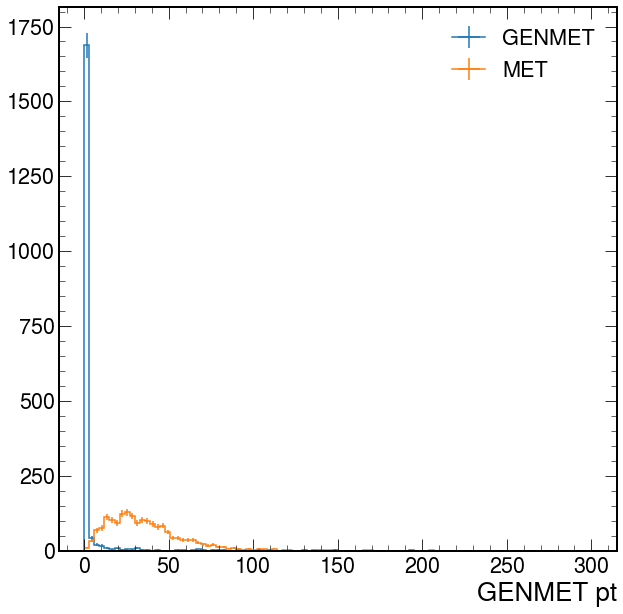

In [49]:
(
    Hist.new.Regular(100, 0, 300, name="GENMET pt", label="GENMET pt")
    .Double()
    .fill(events.GenMET.pt)
    .plot(label="GENMET")
)
(
    Hist.new.Regular(100, 0, 300, name="MET pt", label="MET pt")
    .Double()
    .fill(events.MET.pt)
    .plot(label="MET")
)
plt.legend()
#plt.yscale('log')

In [129]:
genMuons = events.GenPart[abs(events.GenPart.pdgId) == 13]
genMuons = genMuons[genMuons.pt >= 3]
genMuons = genMuons[abs(genMuons.eta) < 2.5]
genMuons = genMuons[genMuons.status < 30]

Gen muons seem to have only 4 status codes (all positive -- final):
- `1` : just final state partilce?
- `23` : particles of the hardest subprocess, outgoing
- `51` : particles produced by final-state-showers, outgoing produced by parton branching
- `52` : particles produced by final-state-showers, outgoing copy of recoiler, with changed momentum

In [43]:
ak.num(genMuons)

<Array [4, 6, 5, 3, 6, 5, ... 6, 8, 6, 6, 4, 3] type='497 * int64'>

In [22]:
ak.flatten(genMuons[genMuons.status != 1]).status == 23

<Array [23, 23, 52, 51, 52, ... 23, 23, 23, 51] type='1075 * int32[parameters={"...'>

In [39]:
Jets_awk = ak.zip(
            {
                "pt": events.Jet.pt,
                "eta": events.Jet.eta,
                "phi": events.Jet.phi,
                "mass": events.Jet.mass,
                "btagDeepB": events.Jet.btagDeepB,
            }
)
jet_awk_Cut = (events.Jet.pt > 30) & (abs(events.Jet.eta) < 2.4)
Jets_correct = Jets_awk[jet_awk_Cut]

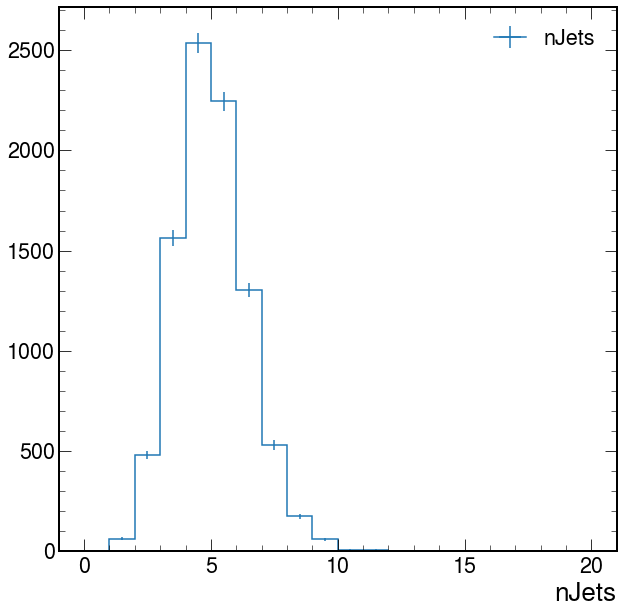

In [72]:
h1 = Hist.new.Regular(20, 0, 20, name="nJets", label="nJets").Double()
h1.fill(ak.num(Jets_correct))
hep.histplot(h1, label="nJets")
plt.legend()
#plt.yscale('log')

In [75]:
btag = Jets_correct.btagDeepB
btag = btag[:, :4]

In [80]:
ak.sum(ak.num(btag) < 4)

2103

In [86]:
btag_fixed = ak.pad_none(btag, target=4, axis=-1)

In [104]:
ak.fill_none(btag_fixed, -2)

<Array [[0.569, 0.011, ... 0.0247, 0.0286]] type='8959 * var * float64'>

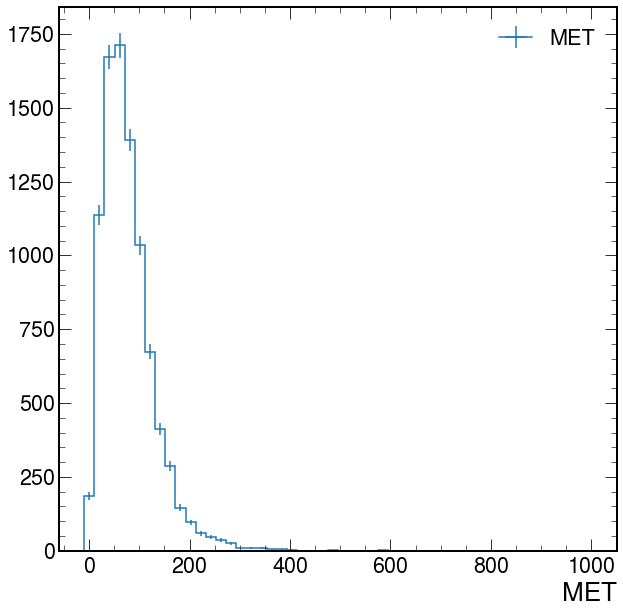

In [73]:
h1 = Hist.new.Regular(50, -10, 1000, name="MET", label="MET").Double()
h1.fill(events.MET.pt)
hep.histplot(h1, label="MET")
plt.legend()
#plt.yscale('log')

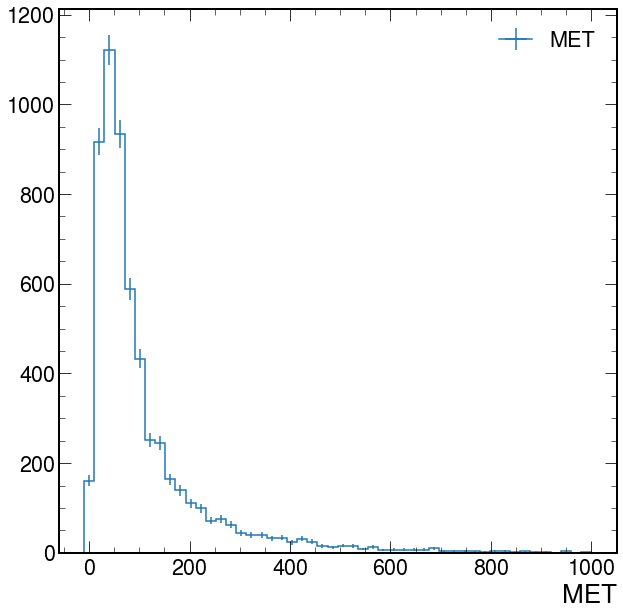

In [71]:
h1 = Hist.new.Regular(50, -10, 1000, name="MET", label="MET").Double()
h1.fill(events.MET.pt)
hep.histplot(h1, label="MET")
plt.legend()
#plt.yscale('log')

In [63]:
h1

Hist(Regular(50, -100, 3000, name='MET', label='MET'), storage=Double()) # Sum: 3404.0 (5349.0 with flow)

In [80]:
ak.max(events.Jet.btagDeepB[:,:2], axis=-1)

<Array [0.569, 0.158, 0.959, ... 1, 0.723] type='8959 * ?float32'>

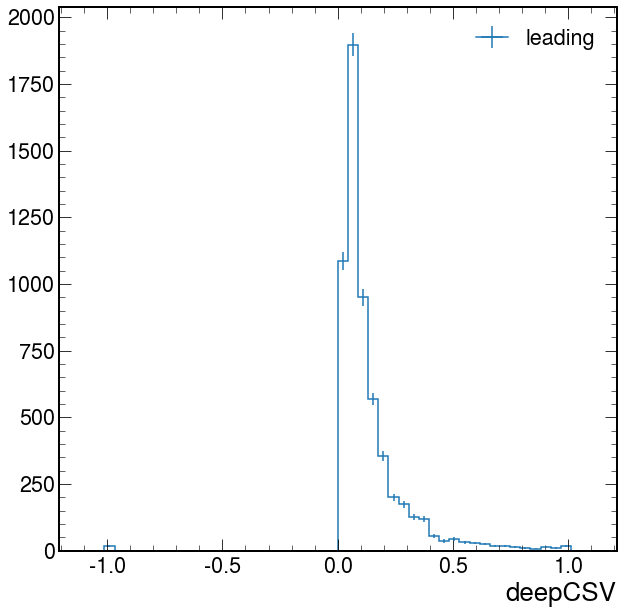

In [85]:
h1 = Hist.new.Regular(50, -1.1, 1.1, name="deepCSV 1", label="deepCSV").Double()
h1.fill(ak.max(events.Jet.btagDeepB[:,:2], axis=-1))
hep.histplot(h1, label="leading")
plt.legend()
#plt.yscale('log')

In [91]:
h = Hist.new.Reg(20,0,20,name='nMuons').Weight()
h.fill(ak.num(events.Muon.mediumId == 1), weight=events.genWeight)

Hist(Regular(20, 0, 20, name='nMuons', label='nMuons'), storage=Weight()) # Sum: WeightedSum(value=37.9161, variance=0.715664)

In [92]:
factor

0.0035316196502400005

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f94b65135b0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

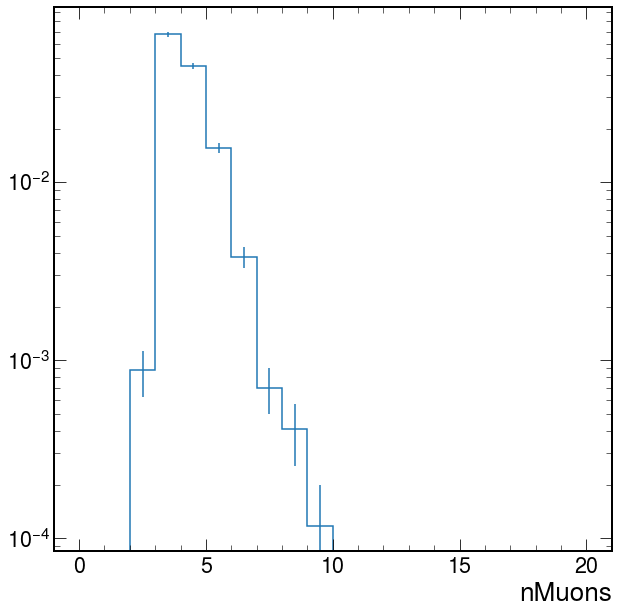

In [93]:
plt.yscale('log')
h *= factor
h.plot()

In [76]:
h.sum()

WeightedSum(value=882.905, variance=388.052)

In [36]:
h_s = h

In [41]:
h_b = h

In [44]:
np.linspace(0,20,21)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [45]:
binning = np.linspace(0,20,21)
alpha = 2
beta = 5
n_bins = h_s.shape[0]
S = np.zeros(n_bins)
B = np.zeros(n_bins)
punzi1 = np.zeros(n_bins)
punzi2 = np.zeros(n_bins)
punzi3 = np.zeros(n_bins)
s_over_b = np.zeros(n_bins)
s_over_b_and_s = np.zeros(n_bins)
for i in range(n_bins):
    S[i] = h_s[i:].sum().value
    B[i] = h_b[i:].sum().value
    epsilon = S[i]/h_s.sum().value
    punziCommon = alpha*math.sqrt(B[i])+(beta/2)*math.sqrt(beta**2+4*alpha*math.sqrt(B[i])+4*B[i])
    punzi1[i] = epsilon / ((alpha**2)/2 + math.sqrt(B[i]))
    punzi2[i] = epsilon / ((beta**2)/2 + punziCommon)
    punzi3[i] = epsilon / ((alpha**2)/8 + 9*(beta**2)/13 + punziCommon)
    if B[i] > 0:
        s_over_b[i] = epsilon / math.sqrt(B[i])
    if (B[i] + S[i]) > 0:
        s_over_b_and_s[i] = epsilon / math.sqrt(B[i] + S[i])
print(f"punzi max at: {binning[np.argmax(punzi3)]}")

punzi max at: 7.0


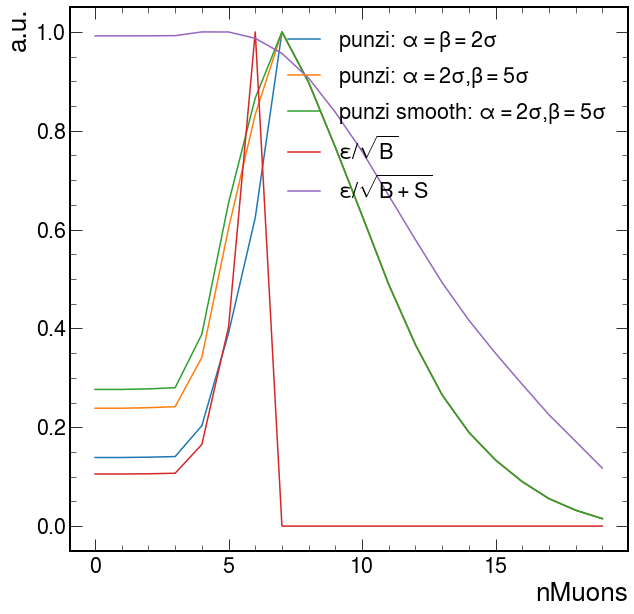

In [48]:
binning = np.linspace(0,19,20)
plt.plot(binning, punzi1/np.max(punzi1), label=r'punzi: $\alpha=\beta=2\sigma$')
plt.plot(binning, punzi2/np.max(punzi2), label=r'punzi: $\alpha=2\sigma$,$\beta=5\sigma$')
plt.plot(binning, punzi3/np.max(punzi3), label=r'punzi smooth: $\alpha=2\sigma$,$\beta=5\sigma$')
plt.plot(binning, s_over_b/np.max(s_over_b), label=r'$\epsilon/\sqrt{B}$')
plt.plot(binning, s_over_b_and_s/np.max(s_over_b_and_s), label=r'$\epsilon/\sqrt{B+S}$')
plt.xlabel('nMuons')
plt.ylabel('a.u.')
plt.legend()

In [31]:
array1 = events.event.to_numpy()[:5]
array2 = events.event.to_numpy()[5:10]

In [32]:
dframe1 = pd.DataFrame(array1, columns=['event'])
dframe2 = pd.DataFrame(array2, columns=['event'])

In [47]:
dframe = pd.concat([dframe1.reset_index(drop=True), dframe2.reset_index(drop=True)])

In [49]:
dframe.reset_index(drop=True)

,event
0,8901672
1,19197151
2,5103767
3,5235490
4,14815079
5,16943876
6,13490734
7,13480518
8,13653190
9,16943876


In [8]:
ak.num(events.HLT.TripleMu_5_3_3_Mass3p8_DZ, axis=0)

195

In [166]:
h_dimuon_mass = hist.Hist.new.Regular(150, 0, 150, name="dimuon mass").Double()

In [392]:
Muons = events.Muon
cutMuons = (
    events.Muon.looseId
    & (events.Muon.pt > 3)
    & (abs(events.Muon.dxy) <= 0.02)
    & (abs(events.Muon.dz) <= 0.1)
    & (abs(events.Muon.eta) < 2.4)
)
Muons = Muons[cutMuons]
eventSelection = ak.num(Muons) >= 3
events = events[eventSelection]
Muons = Muons[eventSelection]
muons = ak.zip(
    {
        "pt": Muons.pt,
        "eta": Muons.eta,
        "phi": Muons.phi,
        "mass": Muons.mass,
        "charge": Muons.pdgId / (-13),
    },
    with_name="Momentum4D",
)

In [393]:
print(Muons[:2].eta)

[[-0.548, 1.51, 0.61], [0.938, 0.928, 0.255]]


In [394]:
print(Muons.nearest(events.Jet)[:2].eta)

[[-0.587, 1.53, 0.625], [0.942, 0.942, 0.253]]


In [395]:
gen_muons_nearest = Muons.nearest(events.GenPart)

In [396]:
gen_muons = events.GenPart[abs(events.GenPart.pdgId) == 13]

In [397]:
gen_muons_final = gen_muons[gen_muons.status == 1]

In [398]:
nearest_muon_final = Muons.nearest(gen_muons_final)

In [24]:
parents = nearest_muon_final[:2]
print("pdgId:", parents.pdgId)
print("status:", parents.status)

pdgId: [[13, -13, 13, -13], [13, -13, -13, 13]]
status: [[1, 1, 1, 1], [1, 1, 1, 1]]


In [35]:
print(parents[:2].pt)

[[131, 90.2, 62.9, 33.6], [63.8, 28.7, 9.47, 4.78]]


In [20]:
gen_muons[0].parent.parent.parent.parent.parent.pdgId

<Array [None, None, 1, 23, ... 1, 23, 23, None] type='14 * ?int32[parameters={"_...'>

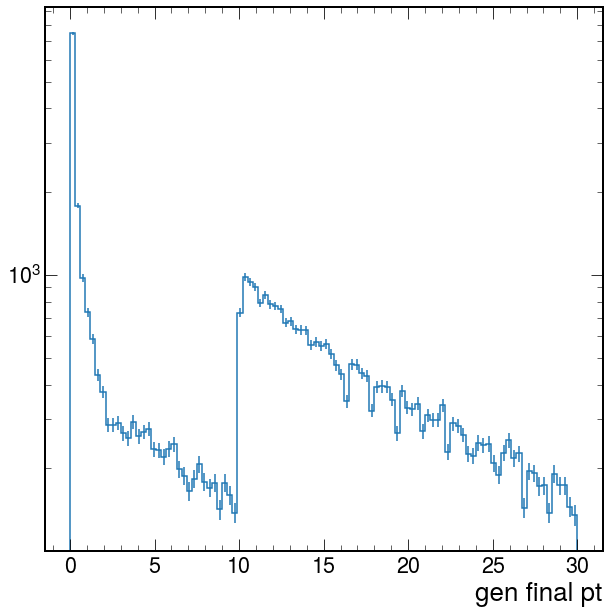

In [208]:
(
    Hist.new.Regular(100, 0, 30, name="gen final pt", label="gen final pt")
    .Double()
    .fill(ak.flatten(events.GenPart.pt[events.GenPart.status == 1]))
    .plot()
);
plt.yscale('log')

## Jet & Muons

In [177]:
Muons = events.Muon
muon_cleaning = (
    Muons.looseId
    & (Muons.pt > 3)
    & (abs(Muons.dxy) <= 0.02)
    & (abs(Muons.dz) <= 0.1)
    & (abs(Muons.eta) < 2.4)
)
Muons = Muons[muon_cleaning]
num_muons_selection = ak.num(Muons) >= 6
Muons = Muons[num_muons_selection]

Jets = events.Jet
jet_cleaning = (
    (Jets.pt > 30)
    & (abs(Jets.eta) < 2.4)
)
Jets = Jets[jet_cleaning]
Jets = Jets[num_muons_selection]

In [178]:
matched_jets = Muons.nearest(Jets)
delta_r = Muons.delta_r(matched_jets)

In [179]:
ak.flatten(delta_r)

<Array [0.229, 0.0913, ... 0.0848, 0.116] type='20 * ?float32'>

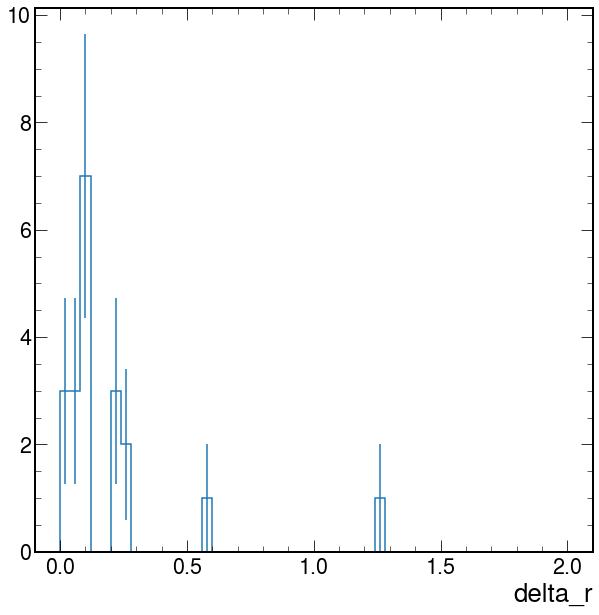

In [180]:
(
    Hist.new
    .Regular(50, 0, 2, name="delta_r", label="delta_r")
    .Double()
    .fill(ak.flatten(delta_r))
    .plot()
);

## Displayed vertices

In [194]:
print(ak.sum(~ak.is_none(events.Jet.matched_muons, axis=-1), axis=-1)[:2])

[[0, 1, 1, 1], [0, 1, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]]


In [199]:
print((events.Jet.pt > 0)[:2])

[[True, True, True, True], ... True, True, True, True, True, True, True, True, True]]


### Find the last non-muon parents for the gen-matched muons
**Step 1:** get the desired muons and the final status gen muons

In [253]:
Muons = events.Muon
muon_cleaning = (
    Muons.looseId
    & (Muons.pt > 3)
    & (abs(Muons.dxy) <= 0.02)
    & (abs(Muons.dz) <= 0.1)
    & (abs(Muons.eta) < 2.4)
)
Muons = Muons[muon_cleaning]
num_muons_selection = ak.num(Muons) >= 3
Muons = Muons[num_muons_selection]

gen_mask_1 = (
    (abs(events.GenPart.pdgId) == 13) &
    (events.GenPart.status == 1)
)
gen_mask_2 = (
    (abs(events.GenPart.pdgId) != 13) &
    (events.GenPart.status == 1)
)

gen_parts_1 = events.GenPart[gen_mask_1]
gen_parts_1 = gen_parts_1[num_muons_selection]
gen_parts_2 = events.GenPart[gen_mask_2]
gen_parts_2 = gen_parts_2[num_muons_selection]
matched_1 = Muons.nearest(gen_parts_1)
matched_2 = Muons.nearest(gen_parts_2)
matched_f_1 = ak.mask(matched_1, Muons.delta_r(matched_1) < 0.1)
matched_f_2 = ak.mask(matched_2, Muons.delta_r(matched_2) < 0.1)

matched_f = ak.where(~ak.is_none(matched_f_1, axis=1), matched_f_1, matched_f_2)

In [260]:
matched_f.phi

<Array [[0.754, -3.08, ... -0.566, -1.29]] type='911 * var * ?float32[parameters...'>

**Step 3:** Form the array with the last non-muon parents

In [261]:
# Begin with the matched gen muons
temp_parents = matched_f
# This mask keeps track of which non-muon parents have not appeared already. Initialize to True
has_not_appeared = ak.full_like(temp_parents.pt, True, dtype=bool)
# The useful parents are the last non-muon parents
last_parents = ak.mask(temp_parents, ~has_not_appeared)
# Terminate when none of the particles is a muon
while ak.any(abs(temp_parents.pdgId) == 13):
    # Create mask of the particles that are not muons and have not already been kept
    mask = (abs(temp_parents.pdgId) != 13) & has_not_appeared
    # Create the parents collection that includes all non-muon parents
    parents = ak.zip(
        {
            "pt": ak.mask(temp_parents, mask).pt,
            "eta": ak.mask(temp_parents, mask).eta,
            "phi": ak.mask(temp_parents, mask).phi,
            "M": ak.mask(temp_parents, mask).mass,
            "pdgId": ak.mask(temp_parents, mask).pdgId,
            "status": ak.mask(temp_parents, mask).status,
        },
        with_name="Momentum4D",
    )
    # Remove the parents that were found from the mask
    has_not_appeared = has_not_appeared & ~mask
    # Add the parents that are not None
    last_parents = ak.where(ak.fill_none(parents.pt, 0) > 0, parents, last_parents)
    # Get the parents of the particles
    temp_parents = temp_parents.parent

... and second-to-last non-muon parents

In [262]:
# Begin with the matched gen muons
temp_parents = matched_f
parents_of_parents = temp_parents.parent
# This mask keeps track of which non-muon parents have not appeared already. Initialize to True
has_not_appeared = ak.full_like(temp_parents.pt, True, dtype=bool)
# The useful parents are the last non-muon parents
last2nd_parents = ak.mask(temp_parents, ~has_not_appeared)
# Terminate when none of the particles is a muon
while ak.any(abs(temp_parents.pdgId) == 13):
    # Create mask of the particles that are not muons and have not already been kept
    mask = (abs(temp_parents.pdgId) != 13) & has_not_appeared
    # Create the parents collection that includes all non-muon parents
    parents = ak.zip(
        {
            "pt": ak.mask(parents_of_parents, mask).pt,
            "eta": ak.mask(parents_of_parents, mask).eta,
            "phi": ak.mask(parents_of_parents, mask).phi,
            "M": ak.mask(parents_of_parents, mask).mass,
            "pdgId": ak.mask(parents_of_parents, mask).pdgId,
            "status": ak.mask(parents_of_parents, mask).status,
        },
        with_name="Momentum4D",
    )
    # Remove the parents that were found from the mask
    has_not_appeared = has_not_appeared & ~mask
    # Add the parents that are not None
    last2nd_parents = ak.where(ak.fill_none(parents.pt, 0) > 0, parents, last2nd_parents)
    # Get the parents of the particles
    temp_parents = temp_parents.parent
    parents_of_parents = temp_parents.parent

... and the first non-proton parents

In [263]:
temp_parents = matched_f
first_parents = ak.mask(temp_parents, ak.full_like(temp_parents.pt, False, dtype=bool))
while ak.any(abs(temp_parents.pdgId)):
    temp_parents = temp_parents.parent
    next_parents = temp_parents.parent
    # Create mask of the particles whose parents are None and have not already been kept
    mask = (abs(ak.fill_none(next_parents.pdgId, 0)) == 0)
    # Create the parents collection that includes all non-muon parents
    parents = ak.zip(
        {
            "pt": ak.mask(temp_parents, mask).pt,
            "eta": ak.mask(temp_parents, mask).eta,
            "phi": ak.mask(temp_parents, mask).phi,
            "M": ak.mask(temp_parents, mask).mass,
            "pdgId": ak.mask(temp_parents, mask).pdgId,
            "status": ak.mask(temp_parents, mask).status,
        },
        with_name="Momentum4D",
    )
    # Add the parents that are not None
    first_parents = ak.where(ak.fill_none(parents.pt, -1) > -1, parents, first_parents)

... and a printout:

In [147]:
print(ak.is_none(matched_f, axis=1))

[[False, False, False, False, False, False, ... True, False, True, True, True, True]]


In [148]:
temp_parents = matched_f[~ak.is_none(matched_f, axis=1)]
while ak.any(abs(temp_parents.pdgId)):
    print(temp_parents.pdgId.to_list())
    temp_parents = temp_parents.parent
    next_parents = temp_parents.parent
    print(temp_parents.pdgId.to_list())
    print()

[[13, 13, -13, -13, 13, 11, 22], [-13, 22, 13, -13], [13, -13]]
[[-531, -421, 421, 421, -421, 21, 221], [421, 111, -421, 411], [-511, 511]]

[[-531, -421, 421, 421, -421, 21, 221], [421, 111, -421, 411], [-511, 511]]
[[-533, 521, 435, 413, 521, None, 21], [423, 2, -423, None], [-513, -5]]

[[-533, 521, 435, 413, 521, None, 21], [423, 2, -423, None], [-513, -5]]
[[21, 21, -531, 21, 21, None, 21], [-521, None, 521, None], [5, None]]

[[21, 21, -531, 21, 21, None, 21], [-521, None, 521, None], [5, None]]
[[21, 21, -533, 21, 21, None, -2], [5, None, 2, None], [5, None]]

[[21, 21, -533, 21, 21, None, -2], [5, None, 2, None], [5, None]]
[[-2, -2, 21, -2, -2, None, None], [21, None, None, None], [None, None]]

[[-2, -2, 21, -2, -2, None, None], [21, None, None, None], [None, None]]
[[None, None, 21, None, None, None, None], [21, None, None, None], [None, None]]

[[None, None, 21, None, None, None, None], [21, None, None, None], [None, None]]
[[None, None, -2, None, None, None, None], [21, No

Voilà:

Status:
[[1, 2, 2], [2, 2, None], [2, 2, 2]]
pdgId:
[[22, -421, 431], [221, 221, None], [421, 431, 421]]
above 550:
[100443, 100443, 4122, 4122, 4122, 5122, ... 4122, 5122, 5122, 5122, 4132, 4122]
33


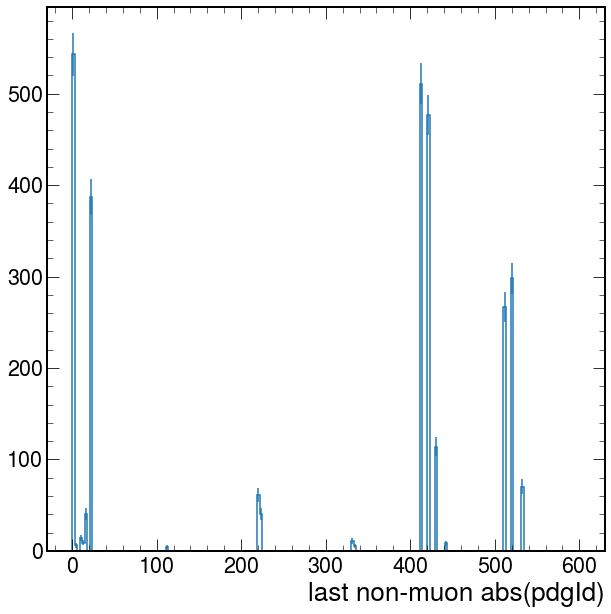

In [264]:
print("Status:")
print(last_parents.status[:3])
print("pdgId:")
print(last_parents.pdgId[:3])
print("above 550:")
print(ak.flatten(last_parents[ak.fill_none(last_parents.pdgId, 0) > 550].pdgId))
print(ak.num(ak.flatten(last_parents[ak.fill_none(last_parents.pdgId, 0) > 550].pdgId), axis=0))
(
    Hist.new
    .Regular(200, 0, 600, name="abs(pdgId)", label="last non-muon abs(pdgId)")#, transform=hist.axis.transform.log)
    .Double()
    .fill(abs(ak.fill_none(ak.flatten(last_parents.pdgId), 0)))
    .plot()
);
#plt.xscale("log")
#plt.yscale("log")

Status:
[[2, 2, 71], [71, 71, None], [2, 2, 2]]
pdgId:
[[111, -413, 4], [3, 3, None], [413, 433, 413]]
above 550:
[5122, 4112, 5224, 4214, 4224, 5214, 4224, 5122, 4222, 5224, 5114, 4314, 5122]
13


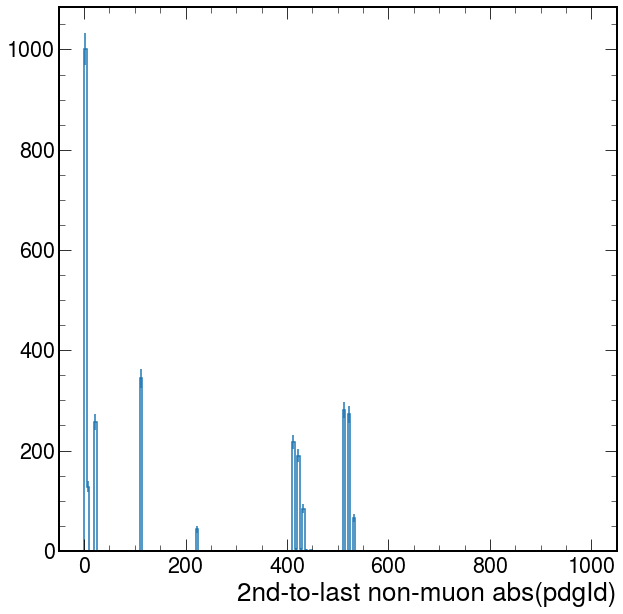

In [266]:
print("Status:")
print(last2nd_parents.status[:3])
print("pdgId:")
print(last2nd_parents.pdgId[:3])
print("above 550:")
print(ak.flatten(last2nd_parents[ak.fill_none(last2nd_parents.pdgId, 0) > 550].pdgId))
print(ak.num(ak.flatten(last2nd_parents[ak.fill_none(last2nd_parents.pdgId, 0) > 550].pdgId), axis=0))
(
    Hist.new
    .Regular(
        200, 0, 1000, 
        name="abs(pdgId)", 
        label="2nd-to-last non-muon abs(pdgId)")#, transform=hist.axis.transform.log)
    .Double()
    .fill(abs(ak.fill_none(ak.flatten(last2nd_parents.pdgId), 0)))
    .plot()
);
#plt.xscale("log")
#plt.yscale("log")

Status:
[[21, 21, 21], [21, 21, None], [21, 21, 21]]
pdgId:
[[21, 21, 21], [21, 21, None], [21, 21, 21]]
above 550:
[]
0


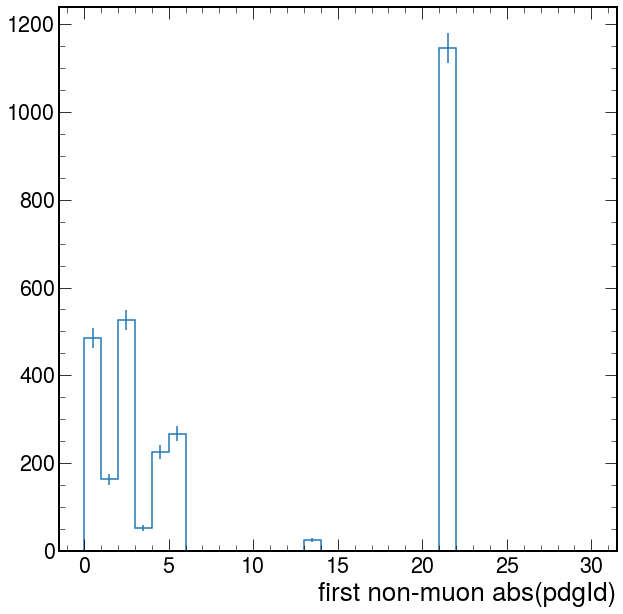

In [268]:
print("Status:")
print(first_parents.status[:3])
print("pdgId:")
print(first_parents.pdgId[:3])
print("above 550:")
print(ak.flatten(first_parents[ak.fill_none(first_parents.pdgId, 0) > 550].pdgId))
print(ak.num(ak.flatten(first_parents[ak.fill_none(first_parents.pdgId, 0) > 550].pdgId), axis=0))
(
    Hist.new
    .Regular(30, 0, 30, name="abs(pdgId)", label="first non-muon abs(pdgId)")#, transform=hist.axis.transform.log)
    .Double()
    .fill(abs(ak.fill_none(ak.flatten(first_parents.pdgId), 0)))
    .plot()
);
#plt.xscale("log")
#plt.yscale("log")

## Check default Nano gen-matching

In [50]:
Muons_s = events.Muon
muon_cleaning = (
    Muons_s.looseId
    & (Muons_s.pt > 3)
    & (abs(Muons_s.dxy) <= 0.02)
    & (abs(Muons_s.dz) <= 0.1)
    & (abs(Muons_s.eta) < 2.4)
)
Muons_s = Muons_s[muon_cleaning]
num_muons_selection = ak.num(Muons_s) >= 3
Muons_s = Muons_s[num_muons_selection]

In [51]:
Muons_s.genPartFlav

<Array [[3, 3, 3, 3, 3, 3, ... 3, 3, 3, 3, 3]] type='1838 * var * uint8[paramete...'>

In [23]:
Muons_b = events.Muon
muon_cleaning = (
    Muons_b.looseId
    & (Muons_b.pt > 3)
    & (abs(Muons_b.dxy) <= 0.02)
    & (abs(Muons_b.dz) <= 0.1)
    & (abs(Muons_b.eta) < 2.4)
)
Muons_b = Muons_b[muon_cleaning]
num_muons_selection = ak.num(Muons_b) >= 3
Muons_b = Muons_b[num_muons_selection]

(0.0, 1.05)

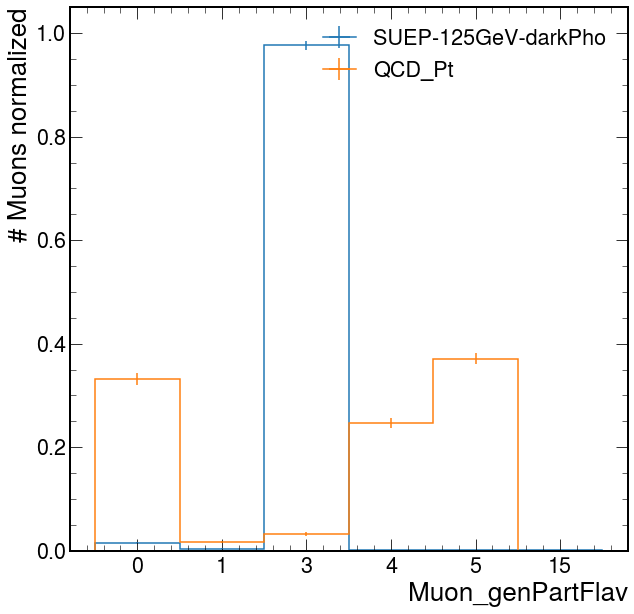

In [60]:
(
    Hist.new
    .IntCategory([0,1,3,4,5,15], name="Muon_genPartFlav", label="Muon_genPartFlav")
    .Double()
    .fill(ak.flatten(Muons_s.genPartFlav))
    .plot(label="SUEP-125GeV-darkPho", density=True)
)
(
    Hist.new
    .IntCategory([0,1,3,4,5,15], name="Muon_genPartFlav", label="Muon_genPartFlav")
    .Double()
    .fill(ak.flatten(Muons_b.genPartFlav))
    .plot(label="QCD_Pt", density=True)
);
plt.legend()
plt.ylabel("# Muons normalized")
#plt.yscale("log")
plt.ylim(0.00, 1.05)

In [272]:
events.Muon.genPartFlav

<Array [[5, 5, 0], [0, 4, ... 4], [5, 0, 0, 5]] type='2856 * var * uint8[paramet...'>

## TTBar sources

In [11]:
Muons = events.Muon
muon_cleaning = (
    Muons.looseId
    & (Muons.pt > 3)
    & (abs(Muons.dxy) <= 0.02)
    & (abs(Muons.dz) <= 0.1)
    & (abs(Muons.eta) < 2.4)
)
Muons = Muons[muon_cleaning]
num_muons_selection = ak.num(Muons) >= 6
Muons = Muons[num_muons_selection]

MET = events.MET[num_muons_selection]

In [12]:
print(Muons.pt.to_numpy())

ValueError: in ListOffsetArray64, cannot convert to RegularArray because subarray lengths are not regular

(https://github.com/scikit-hep/awkward-1.0/blob/1.7.0/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

In [137]:
print(Muons.genPartFlav.to_numpy())

[[ 4  4  5  5  5  0]
 [ 4  1  1  5  4  0]
 [ 1  5  4  4  5  0]
 [ 1  5 15  5  5  4]
 [ 1  0  0  5  0  0]
 [ 4  5  5  5  0  5]
 [ 0  4  4  5  5  0]]


In [138]:
print(Muons.genPartIdx.to_numpy())

[[66 54 72 64 83 -1]
 [57 17 18 60 46 -1]
 [17 75 66 72 77 -1]
 [20 64 48 75 70 56]
 [15 -1 -1 45 -1 -1]
 [65 85 75 71 -1 78]
 [-1 46 53 65 62 -1]]


In [139]:
GenPart = events.GenPart[num_muons_selection]

In [140]:
wbosons = GenPart[abs(GenPart.pdgId) == 24]
wbosons = wbosons[abs(wbosons.children.pdgId[:,:,0]) != 24]

In [141]:
print(wbosons.children.pdgId.to_list())

[[[4, -3], [3, -4]], [[14, -13], [13, -14]], [[14, -13], [3, -4]], [[16, -15], [13, -14]], [[14, -13], [1, -2]], [[2, -1], [3, -4]], [[4, -3], [3, -4]]]


In [142]:
print(wbosons.status.to_list())

[[52, 52], [52, 52], [52, 52], [52, 52], [52, 22], [52, 52], [52, 22]]


### Calculate and plot the mT

In [13]:
mT = np.sqrt(2*Muons.pt*MET.pt*(1-np.cos(Muons.delta_phi(MET))));

In [17]:
ak.flatten(mT)

<Array [9.14, 2.2, 6.49, ... 29.9, 35.3, 31.3] type='5920 * float32'>

In [18]:
weights = events.genWeight[num_muons_selection]

In [22]:
ak.flatten(ak.broadcast_arrays(weights, mT)[0])

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='5920 * float32[parameters=...'>

In [ ]:
events.Muon.

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fb59f0235e0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fb59ef18580>, text=[])

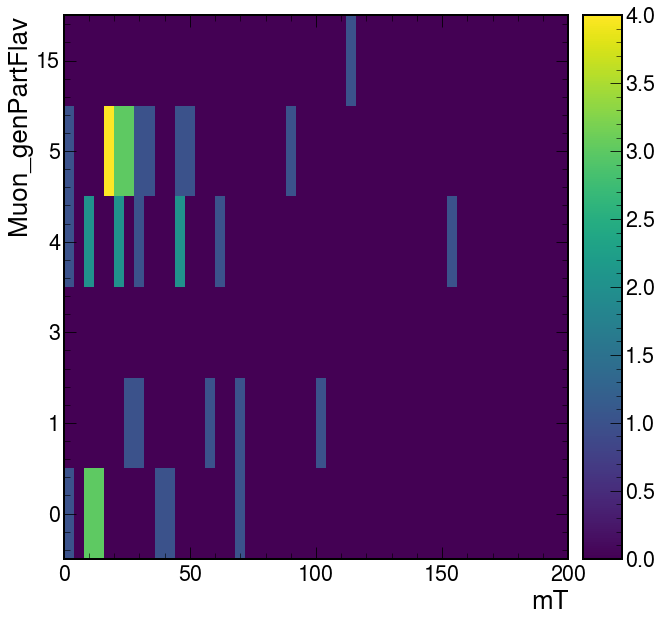

In [174]:
(
    Hist.new
    .Regular(100, 0, 100, name="mT", label="mT")
    .IntCategory([0,1,3,4,5,15], name="Muon_genPartFlav", label="Muon_genPartFlav")
    .Double()
    .fill(ak.flatten(mT), ak.flatten(Muons.genPartFlav))
    .plot2d()
)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fb597c46d60>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fb597c5ce80>, text=[])

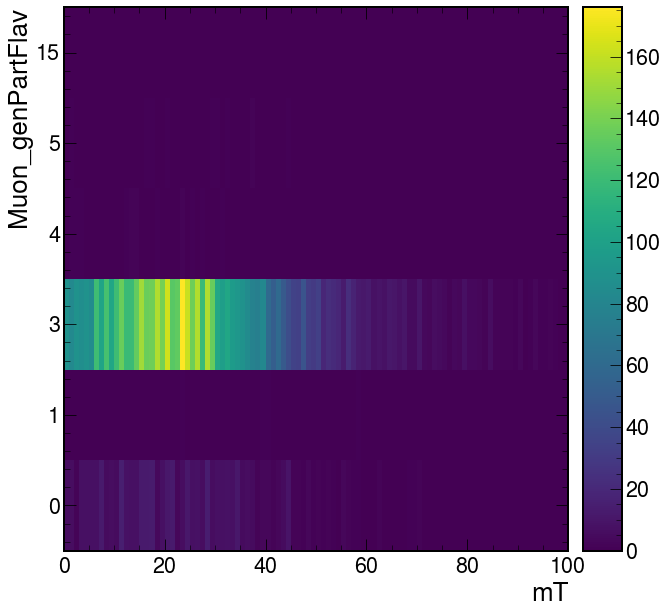

In [180]:
(
    Hist.new
    .Regular(100, 0, 100, name="mT", label="mT")
    .IntCategory([0,1,3,4,5,15], name="Muon_genPartFlav", label="Muon_genPartFlav")
    .Double()
    .fill(ak.flatten(mT), ak.flatten(Muons.genPartFlav))
    .plot2d()
)

## Check status flags

In [115]:
def check_flag(n, i):
    "Checks the nth flag for input i"
    return i & (2 ** n) != 0

In [150]:
genParts = events.GenPart[events.GenPart.status == 1]

In [159]:
#print(genParts[0].statusFlags.to_list())
for flag in range(0, 15):
    print(f"\n flag={flag}")
    print(genParts[check_flag(flag, genParts.statusFlags)][0].status.to_list())
    print(genParts[check_flag(flag, genParts.statusFlags)][0].pdgId.to_list())
    print([int(i) for i in check_flag(flag, genParts.statusFlags)[0].to_list()])


 flag=0
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=1
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=2
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=3
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=4
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=5
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=6
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[-11, 12, 22, 22, 14, -13, 22, 22, 22, 13, -14, 22, 22, 22, 22, 22, 22]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

 flag=7
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=8
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=9
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=10
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=11
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=12
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[-11, 12, 22, 

## Pt spectrum of matched vs unmatched muons

In [12]:
Muons = events.Muon
muon_cleaning = (
    Muons.looseId
    & (Muons.pt > 3)
    & (abs(Muons.dxy) <= 0.02)
    & (abs(Muons.dz) <= 0.1)
    & (abs(Muons.eta) < 2.4)
)
Muons = Muons[muon_cleaning]
num_muons_selection = ak.num(Muons) >= 3
Muons = Muons[num_muons_selection]

gen_mask = (events.GenPart.status == 1)

gen_parts = events.GenPart[gen_mask]
gen_parts = gen_parts[num_muons_selection]
matched = Muons.nearest(gen_parts)
matched_f = Muons[Muons.delta_r(matched) < 0.1]
unmatched_f = Muons[Muons.delta_r(matched) > 0.1]

In [17]:
Muons_s = events.Muon
muon_cleaning = (
    Muons_s.looseId
    & (Muons_s.pt > 3)
    & (abs(Muons_s.dxy) <= 0.02)
    & (abs(Muons_s.dz) <= 0.1)
    & (abs(Muons_s.eta) < 2.4)
)
Muons_s = Muons_s[muon_cleaning]
num_muons_selection = ak.num(Muons_s) >= 3
Muons_s = Muons_s[num_muons_selection]

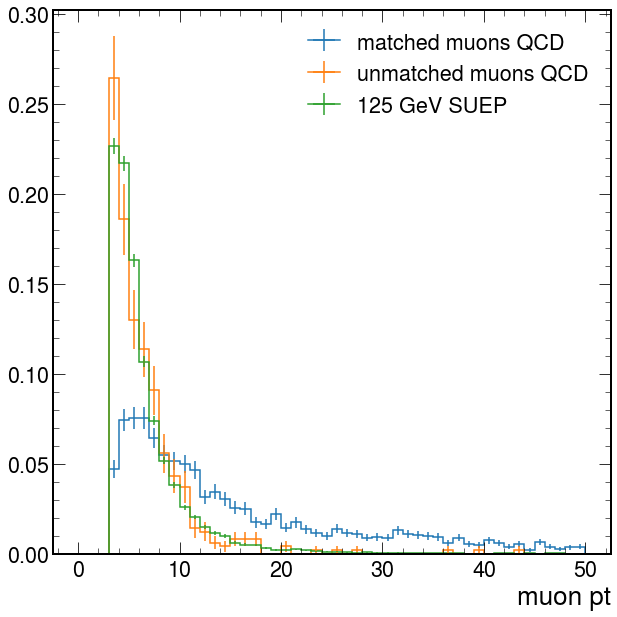

In [21]:
(
    Hist.new.Regular(50, 0, 50, name="muon pt", label="muon pt")
    .Double()
    .fill(ak.flatten(matched_f.pt))
    .plot(label="matched muons QCD", density=True)
)
(
    Hist.new.Regular(50, 0, 50, name="muon pt", label="muon pt")
    .Double()
    .fill(ak.flatten(unmatched_f.pt))
    .plot(label="unmatched muons QCD", density=True)
)
(
    Hist.new.Regular(50, 0, 50, name="muon pt", label="muon pt")
    .Double()
    .fill(ak.flatten(Muons_s.pt))
    .plot(label="125 GeV SUEP", density=True)
)
plt.legend()
#plt.yscale('log')

## Distance between gen-matched and reco muons

In [135]:
Muons = events.Muon
muon_cleaning = (
    Muons.looseId
    & (Muons.pt > 3)
    & (abs(Muons.dxy) <= 0.02)
    & (abs(Muons.dz) <= 0.1)
    & (abs(Muons.eta) < 2.4)
)
Muons = Muons[muon_cleaning]
num_muons_selection = ak.num(Muons) >= 6
Muons = Muons[num_muons_selection]

gen_mask_1 = (
    (abs(events.GenPart.pdgId) == 13) &
    (events.GenPart.status == 1)
)
gen_mask_2 = (
    (abs(events.GenPart.pdgId) != 13) &
    (events.GenPart.status == 1)
)

gen_parts_1 = events.GenPart[gen_mask_1]
gen_parts_1 = gen_parts_1[num_muons_selection]
gen_parts_2 = events.GenPart[gen_mask_2]
gen_parts_2 = gen_parts_2[num_muons_selection]
matched_1 = Muons.nearest(gen_parts_1)
matched_2 = Muons.nearest(gen_parts_2)
matched_f_1 = ak.mask(matched_1, Muons.delta_r(matched_1) < 0.1)
matched_f_2 = ak.mask(matched_2, Muons.delta_r(matched_2) < 0.1)

matched_f = ak.where(~ak.is_none(matched_f_1, axis=1), matched_f_1, matched_f_2)

In [136]:
print(matched_f_1.pt[0])
print(matched_f_2.pt[0])
print(matched_f.pt[0])

[67, 49, 32.8, 21.4, 49, None, None]
[12.3, 22.8, 12.3, 25.2, 22.8, 1.54, 15.7]
[67, 49, 32.8, 21.4, 49, 1.54, 15.7]


In [137]:
ak.sum(ak.is_none(ak.flatten(matched_f))) / len(ak.flatten(matched_f))

0.35

In [140]:
~ak.is_none(matched_f_1, axis=1)

<Array [[True, True, True, ... False, False]] type='3 * var * bool'>

In [142]:
print(
    Muons.delta_r(matched_f)[0], 
    Muons.delta_r(matched_f)[1], 
    Muons.delta_r(matched_f)[2],
    #Muons.delta_r(matched_f)[3],
    #Muons.delta_r(matched_f)[4],
)

[0.00343, 0.00201, 0.00448, 0.000444, 0.000732, 0.035, 0.0109] [0.000644, None, 0.0564, 0.00199, None, 0.000504] [0.00228, None, 0.00253, None, None, None, None]


In [85]:
print(matched_f.pdgId[:5])
print(matched_f.pt[:5])
print(Muons.delta_r(matched_f)[:5])
print()
print(matched_f.children.pdgId[:3])
print(matched_f.children.status[:3])
print()
print(matched_f.children.children.pdgId[:3])
print(matched_f.children.children.status[:3])

[[13, -13, None, -13, 22, None], [13, ... None], [-13, 13, -13, None, None, None]]
[[88.5, 41.8, None, 10.4, 15.1, None], ... [54, 27.7, 13.6, None, None, None]]
[[0.000366, 0.000782, None, 0.000503, 0.0452, ... 0.00109, None, None, None]]

[[[], [], None, [], [], None], ... [], [], [], [], []], [[], [], [], None, [], None]]
[[[], [], None, [], [], None], ... [], [], [], [], []], [[], [], [], None, [], None]]

[[[], [], None, [], [], None], ... [], [], [], [], []], [[], [], [], None, [], None]]
[[[], [], None, [], [], None], ... [], [], [], [], []], [[], [], [], None, [], None]]


In [86]:
matched_f.children[1]

<GenParticleArray [[], [], [], [], [], [], []] type='7 * option[var * ?genParticle]'>

In [87]:
print(ak.flatten(Muons[ak.fill_none(matched_f.eta, 0) == 0].eta))

[-1.02, -0.0196, -2.02, -1.91, -0.77, -0.734, 1.32, 1.18]


In [88]:
ak.flatten(Muons.eta)

<Array [-0.447, -0.281, -1.02, ... 1.32, 1.18] type='31 * float32[parameters={"_...'>

In [89]:
delta_r = ak.fill_none(ak.flatten(Muons.delta_r(matched_f)), 0)

In [90]:
ak.sum(delta_r > 0.1, axis=0) / len(delta_r)

0.0

In [91]:
print(delta_r[delta_r > 0.1])

[]


In [92]:
print(ak.flatten(matched_f.pdgId)[delta_r > 0.1])
print(ak.flatten(matched_f.status)[delta_r > 0.1])

[]
[]


In [93]:
print(ak.flatten(matched_f.pt)[delta_r > 0.1])

[]


In [94]:
print(ak.flatten(Muons.pt)[delta_r > 0.1])

[]


In [95]:
print(delta_r > 0.1)

[False, False, False, False, False, False, ... False, False, False, False, False]


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f28a8562190>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

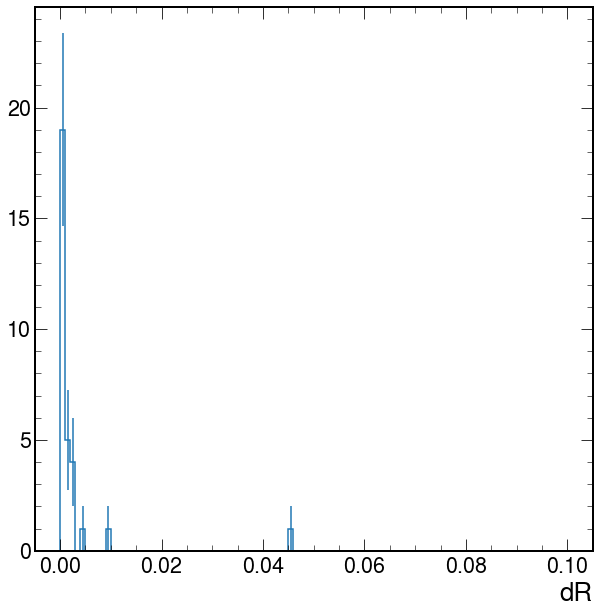

In [100]:
(
    Hist.new
    .Regular(100, 0, 0.1, name="dR", label="dR")#, transform=hist.axis.transform.log)
    .Double()
    .fill(ak.fill_none(ak.flatten(Muons.delta_r(matched_f)), 0))
    .plot()
)
#plt.xscale('log')
#plt.yscale('log');

## Check ak4jets for muon containment

In [239]:
Muons = events.Muon
muon_cleaning = (
    Muons.looseId
    & (Muons.pt > 3)
    & (abs(Muons.dxy) <= 0.02)
    & (abs(Muons.dz) <= 0.1)
    & (abs(Muons.eta) < 2.4)
)
Muons = Muons[muon_cleaning]
num_muons_selection = ak.num(Muons) >= 4
Muons = Muons[num_muons_selection]

In [240]:
ak4jets = events.Jet
jet_cleaning = (
    (ak4jets.pt > 15)
    & (abs(ak4jets.eta) < 2.4)
)
ak4jets = ak4jets[jet_cleaning]
ak4jets = ak4jets[num_muons_selection]

In [241]:
delta_r = ak4jets.metric_table(Muons)
nMuonsInJets = ak.sum(delta_r < 0.4, axis=-1)
nMuonsInJets = ak.sort(nMuonsInJets, axis=-1, ascending=False)
nMuonsInJets = ak.fill_none(ak.pad_none(nMuonsInJets, 5, axis=-1), 0)

In [242]:
nMuonsInJets

<Array [[2, 1, 1, 1, 1, 1, ... 0, 0, 0, 0, 0]] type='5751 * var * int64'>

In [243]:
print(nMuonsInJets[:,0])
print(nMuonsInJets[:,1])
print(nMuonsInJets[:,2])
print(nMuonsInJets[:,3])
print(ak.sum(nMuonsInJets[:,4:], axis=1))

[2, 3, 1, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, ... 4, 6, 2, 7, 3, 2, 1, 3, 1, 11, 3, 1, 8]
[1, 2, 1, 1, 2, 1, 1, 3, 1, 2, 2, 2, 1, 1, ... 2, 3, 1, 4, 2, 1, 1, 2, 1, 6, 2, 1, 5]
[1, 2, 1, 1, 2, 1, 0, 2, 1, 2, 2, 1, 1, 1, ... 1, 2, 1, 4, 2, 1, 1, 1, 1, 3, 2, 1, 5]
[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, ... 1, 2, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3]
[3, 5, 0, 1, 2, 0, 0, 5, 0, 1, 7, 1, 1, 0, ... 3, 4, 2, 5, 3, 4, 2, 0, 1, 6, 2, 2, 4]


In [244]:
print(ak.max(nMuonsInJets[:,0]))
print(ak.max(nMuonsInJets[:,1]))
print(ak.max(nMuonsInJets[:,2]))
print(ak.max(nMuonsInJets[:,3]))
print(ak.max(ak.sum(nMuonsInJets[:,4:], axis=1)))

21
11
10
8
17


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f6534647880>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f65345d8850>, text=[])

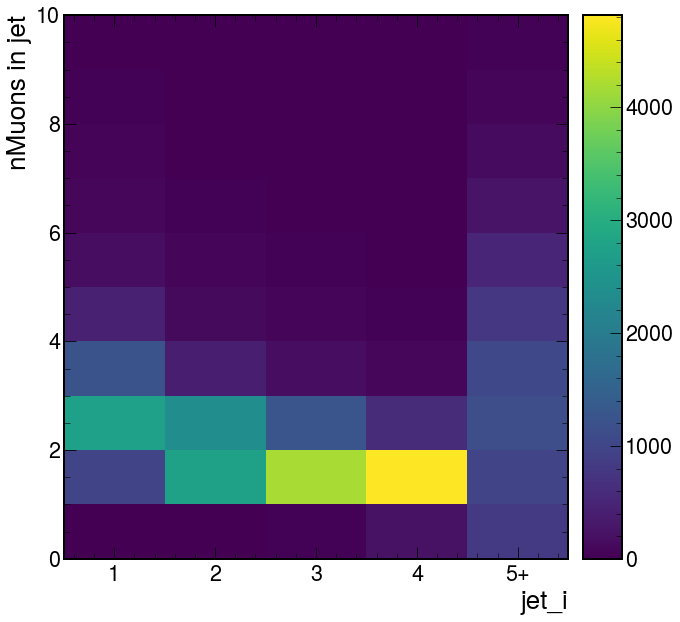

In [245]:
(
    Hist.new
    .StrCategory(["1", "2", "3", "4", "5+"], name="jet_i", label="jet_i")
    .Regular(10, 0, 10, name="nMuonsInJet", label="nMuons in jet")
    .Double()
    .fill("1", nMuonsInJets[:,0])
    .fill("2", nMuonsInJets[:,1])
    .fill("3", nMuonsInJets[:,2])
    .fill("4", nMuonsInJets[:,3])
    .fill("5+", ak.sum(nMuonsInJets[:,4:], axis=1))
.plot2d()
)

## Check ak8jets for muon containment

In [10]:
Muons = ak.zip(
    {
        "pt": events.Muon.pt,
        "eta": events.Muon.eta,
        "phi": events.Muon.phi,
        "mass": events.Muon.mass,
    },
    with_name="Momentum4D"
)
muon_cleaning = (
    events.Muon.looseId
    & (events.Muon.pt > 3)
    & (abs(events.Muon.dxy) <= 0.02)
    & (abs(events.Muon.dz) <= 0.1)
    & (abs(events.Muon.eta) < 2.4)
)
Muons = Muons[muon_cleaning]
num_muons_selection = ak.num(Muons) >= 4
Muons = Muons[num_muons_selection]

In [11]:
pfcands = ak.zip(
    {
        "pt": events.PFCands.trkPt,
        "eta": events.PFCands.trkEta,
        "phi": events.PFCands.trkPhi,
        "mass": events.PFCands.mass,
    },
    with_name="Momentum4D",
)
cutPFCands = (
    (events.PFCands.fromPV > 1)
    & (events.PFCands.trkPt >= 0.75)
    & (abs(events.PFCands.trkEta) <= 2.5)
    & (abs(events.PFCands.dz) < 10)
    & (events.PFCands.dzErr < 0.05)
)
pfcands = pfcands[cutPFCands]

jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 1.5)
cluster = fastjet.ClusterSequence(pfcands, jetdef)
ak15jets = cluster.inclusive_jets(min_pt=30)
ak15clusters = cluster.constituents(min_pt=30)

jet_cleaning = (
    (ak15jets.pt > 30)
    & (abs(ak15jets.eta) < 2.4)
)
ak15jets = ak15jets[jet_cleaning]
ak15jets = ak15jets[num_muons_selection]
ak15clusters = ak15clusters[jet_cleaning]
ak15clusters = ak15clusters[num_muons_selection]

#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [12]:
ak.where(ak.num(ak15jets) == 1)

(<Array [179, 243, 264, ... 901, 1034, 1425] type='7 * int64'>,)

In [22]:
def getTopTwoJets(ak_inclusive_jets, ak_inclusive_cluster):
    # order the reclustered jets by pT (will take top 2 for ISR removal method)
    # make sure there are at least 2 entries in the array
    ak_inclusive_jets = ak.pad_none(ak_inclusive_jets, 2, axis=1)
    ak_inclusive_cluster = ak.pad_none(ak_inclusive_cluster, 2, axis=1)
    highpt_jet = ak.argsort(ak_inclusive_jets.pt, axis=1, ascending=False, stable=True)
    jets_pTsorted = ak_inclusive_jets[highpt_jet]
    clusters_pTsorted = ak_inclusive_cluster[highpt_jet]

    # at least 2 tracks in SUEP
    singletrackCut = ak.num(clusters_pTsorted[:, 0]) > 1
    jets_pTsorted = jets_pTsorted[singletrackCut]
    clusters_pTsorted = clusters_pTsorted[singletrackCut]

    # number of constituents per jet, sorted by pT
    nconst_pTsorted = ak.fill_none(ak.num(clusters_pTsorted, axis=-1), 0)
    print(nconst_pTsorted[179, 1],nconst_pTsorted[179, 0])
    print(nconst_pTsorted[179, 1] <= nconst_pTsorted[179, 0])
    print(jets_pTsorted[179, 0])
    
    print(ak.where(
        nconst_pTsorted[:, 1] <= nconst_pTsorted[:, 0],
        jets_pTsorted[:, 0],
        jets_pTsorted[:, 1],
    )[179])
    
    # Top 2 pT jets. If jet1 has fewer tracks than jet2 then swap
    SUEP_cand = ak.where(
        nconst_pTsorted[:, 1] <= nconst_pTsorted[:, 0],
        jets_pTsorted[:, 0],
        jets_pTsorted[:, 1],
    )
    SUEP_cand = ak.where(ak.is_none(SUEP_cand), jets_pTsorted[:, 0], SUEP_cand)
    print(SUEP_cand[179])

    return SUEP_cand

In [23]:
SUEP_cand = getTopTwoJets(ak15jets, ak15clusters)

0 118
True
{px: 220, py: -97.8, pz: -135, E: 353}
None
{px: 220, py: -97.8, pz: -135, E: 353}


In [24]:
ak.is_none(SUEP_cand)[179]

False

In [54]:
ak_inclusive_jets = ak.pad_none(ak15jets, 2, axis=1)
ak_inclusive_cluster = ak.pad_none(ak15clusters, 2, axis=1)
highpt_jet = ak.argsort(ak_inclusive_jets.pt, axis=1, ascending=False, stable=True)
jets_pTsorted = ak_inclusive_jets[highpt_jet]
clusters_pTsorted = ak_inclusive_cluster[highpt_jet]
singletrackCut = ak.num(clusters_pTsorted[:, 0]) > 1
jets_pTsorted = jets_pTsorted[singletrackCut]
clusters_pTsorted = clusters_pTsorted[singletrackCut]
nconst_pTsorted = ak.fill_none(ak.num(clusters_pTsorted, axis=-1), 0)

In [55]:
nconst_pTsorted[179]

<Array [118, 0] type='2 * int64'>

In [63]:
SUEP_cand = ak.where(
    nconst_pTsorted[:, 1] <= nconst_pTsorted[:, 0],
    jets_pTsorted[:, 0],
    jets_pTsorted[:, 1],
)

In [75]:
jets_pTsorted[179, 1]

In [73]:
ak.where(nconst_pTsorted[:, 1] <= nconst_pTsorted[:, 0],0,1)[180]

0

In [41]:
a, b = ak.unzip(
    ak.cartesian([ak15jets, Muons], axis=1, nested=True)
)
delta_r = a.deltaR(b)
nMuonsInJets = ak.sum(delta_r < 1.5, axis=-1)
nMuonsInJets = ak.sort(nMuonsInJets, axis=-1, ascending=False)
nMuonsInJets = ak.fill_none(ak.pad_none(nMuonsInJets, 3, axis=-1), 0)

In [42]:
nMuonsInJets

<Array [[4, 2, 2, 0], [7, ... 0], [19, 9, 0]] type='5751 * var * int64'>

In [43]:
print(nMuonsInJets[:,0])
print(nMuonsInJets[:,1])
print(ak.sum(nMuonsInJets[:,2:], axis=1))

[4, 7, 2, 4, 6, 4, 4, 9, 4, 5, 7, 5, 5, ... 13, 3, 16, 5, 6, 4, 4, 2, 17, 8, 4, 19]
[2, 5, 2, 2, 3, 3, 1, 4, 3, 3, 6, 4, 3, 0, ... 4, 1, 3, 6, 5, 3, 3, 2, 2, 4, 1, 3, 9]
[2, 0, 1, 0, 2, 2, 0, 2, 1, 0, 4, 2, 1, 0, ... 0, 0, 2, 5, 3, 2, 2, 0, 1, 0, 1, 1, 0]


In [44]:
print(ak.max(nMuonsInJets[:,0]))
print(ak.max(nMuonsInJets[:,1]))
print(ak.max(ak.sum(nMuonsInJets[:,2:], axis=1)))

32
17
13


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f64de063550>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f64de4adeb0>, text=[])

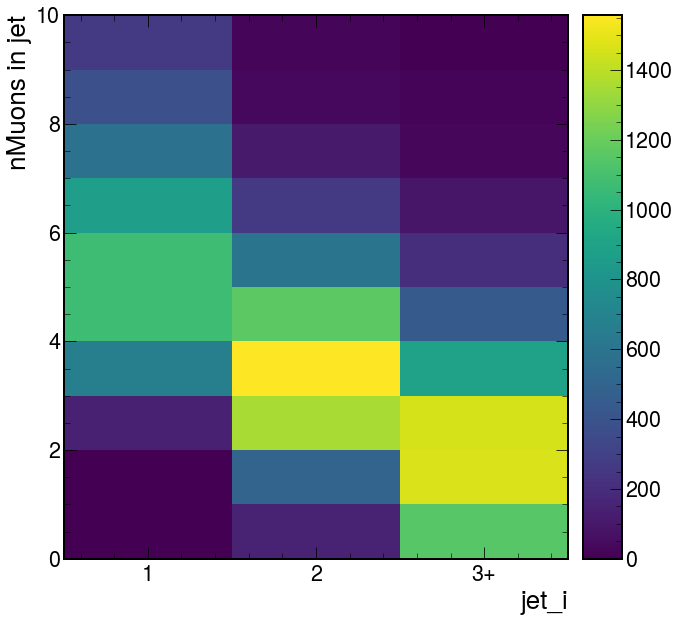

In [45]:
(
    Hist.new
    .StrCategory(["1", "2", "3+"], name="jet_i", label="jet_i")
    .Regular(10, 0, 10, name="nMuonsInJet", label="nMuons in jet")
    .Double()
    .fill("1", nMuonsInJets[:,0])
    .fill("2", nMuonsInJets[:,1])
    .fill("3+", ak.sum(nMuonsInJets[:,2:], axis=1))
.plot2d()
)

### Invariant mass tests

In [85]:
Zs = ak.combinations(muons, n=2, axis=-1, highlevel=True, with_name="Momentum4D")
mu1, mu2 = ak.unzip(Zs)
opposite_charges = (mu1.charge != mu2.charge)
dimuon = mu1[opposite_charges] + mu2[opposite_charges]

In [90]:
weights = np.ones(len(events))
weights

array([1., 1., 1., ..., 1., 1., 1.])

In [92]:
ak.broadcast_arrays(weights, dimuon.pt)[0]

<Array [[], [], [1, 1], ... [1], [], [1]] type='15620 * var * float64'>

In [88]:
dimuon.pt

<Array [[], [], [8.88, 12.5, ... [], [3.07]] type='15620 * var * float32'>

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f0e13e475e0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

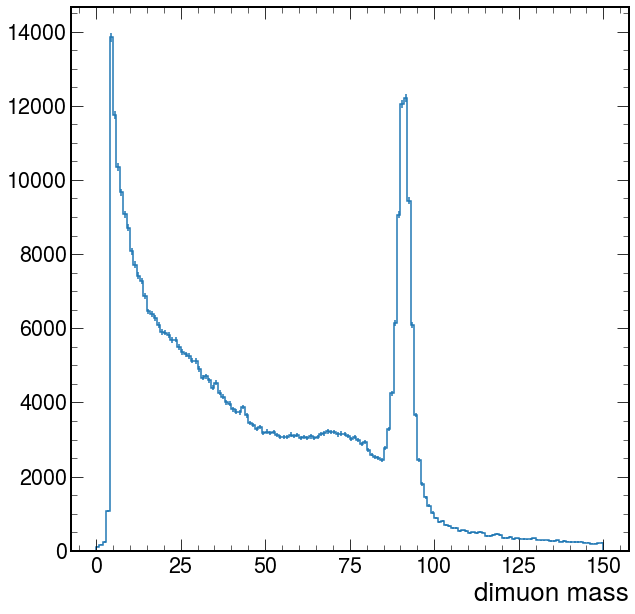

In [193]:
h_dimuon_mass.fill(ak.flatten(dimuon.mass)).plot()

In [83]:
cutflow.fill(len(events) * ['nMuon_mediumId > 6'], weight=events.genWeight)


Hist(StrCategory(['total', 'trigger', 'nMuon_mediumId > 6'], name='cutflow', label='cutflow'), storage=Weight()) # Sum: WeightedSum(value=3728.77, variance=69.3721)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f94bc06d940>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

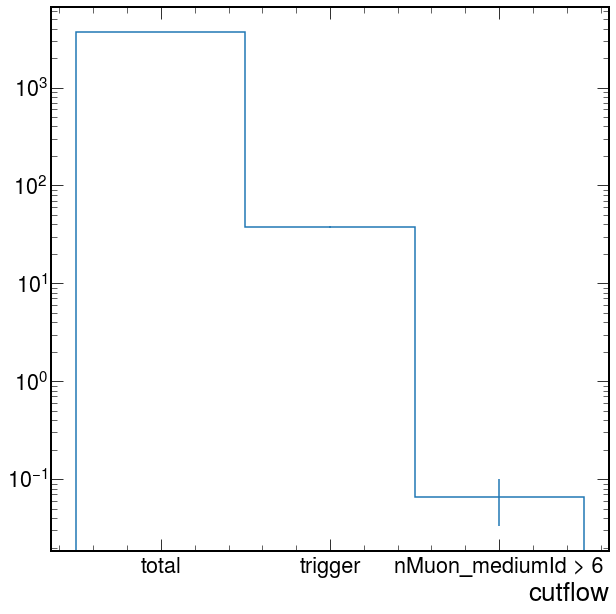

In [84]:
plt.yscale('log')
cutflow *= factor
cutflow.plot()

In [37]:
cat1 = Muons.mediumId
cat2 = Muons.isTracker & ~Muons.mediumId
cat3 = ~cat1 & ~cat2

(array([9243.,  242.,   38.,    2.,    0.,    0.,    0.,    0.,    0.]),
 array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
         5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ]),
 [<matplotlib.patches.Polygon at 0x7f7c19fac9d0>])

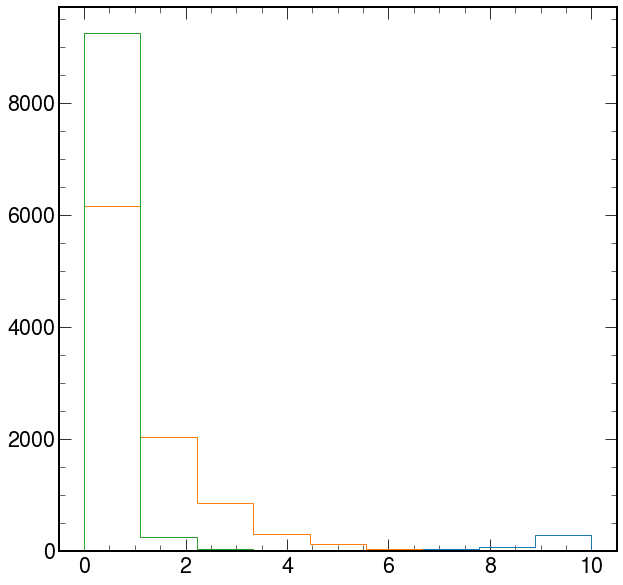

In [38]:
plt.hist(ak.sum(cat1, axis=-1), bins=np.linspace(0,10,10), histtype='step', label='cat1')
plt.hist(ak.sum(cat2, axis=-1), bins=np.linspace(0,10,10), histtype='step', label='cat1')
plt.hist(ak.sum(cat3, axis=-1), bins=np.linspace(0,10,10), histtype='step', label='cat1')

In [13]:
pfcands = ak.zip(
    {
        "pt": events.PFCands.trkPt,
        "eta": events.PFCands.trkEta,
        "phi": events.PFCands.trkPhi,
        "mass": events.PFCands.mass,
    },
    with_name="Momentum4D",
)
cutPFCands = (
    (events.PFCands.fromPV > 1)
    & (events.PFCands.trkPt >= 0.75)
    & (abs(events.PFCands.trkEta) <= 2.5)
    & (abs(events.PFCands.dz) < 10)
    & (events.PFCands.dzErr < 0.05)
)
pfcands = pfcands[cutPFCands]

In [22]:
import fastjet

In [23]:
jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 1.5)
cluster = fastjet.ClusterSequence(pfcands, jetdef)
ak_inclusive_jets = cluster.inclusive_jets()
ak_inclusive_cluster = cluster.constituents()
minPtCut = ak_inclusive_jets.pt > 150
ak_inclusive_jets = ak_inclusive_jets[minPtCut]
ak_inclusive_cluster = ak_inclusive_cluster[minPtCut]

#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [25]:
indices = np.arange(0, len(pfcands))
clusterCut = ak.num(ak_inclusive_jets, axis=1) > 1
ak_inclusive_cluster = ak_inclusive_cluster[clusterCut]
ak_inclusive_jets = ak_inclusive_jets[clusterCut]
pfcands = pfcands[clusterCut]
indices = indices[clusterCut]

In [30]:
highpt_jet = ak.argsort(ak_inclusive_jets.pt, axis=1, ascending=False, stable=True)
jets_pTsorted = ak_inclusive_jets[highpt_jet]
clusters_pTsorted = ak_inclusive_cluster[highpt_jet]

In [34]:
singletrackCut = (ak.num(clusters_pTsorted[:, 0]) > 1) & (
    ak.num(clusters_pTsorted[:, 1]) > 1
)
jets_pTsorted = jets_pTsorted[singletrackCut]
clusters_pTsorted = clusters_pTsorted[singletrackCut]
pfcands = pfcands[singletrackCut]
indices = indices[singletrackCut]

In [36]:
nconst_pTsorted = ak.num(clusters_pTsorted, axis=-1)

SUEP_cand = ak.where(
    nconst_pTsorted[:, 1] <= nconst_pTsorted[:, 0],
    jets_pTsorted[:, 0],
    jets_pTsorted[:, 1],
)
ISR_cand = ak.where(
    nconst_pTsorted[:, 1] > nconst_pTsorted[:, 0],
    jets_pTsorted[:, 0],
    jets_pTsorted[:, 1],
)
SUEP_cluster_tracks = ak.where(
    nconst_pTsorted[:, 1] <= nconst_pTsorted[:, 0],
    clusters_pTsorted[:, 0],
    clusters_pTsorted[:, 1],
)
ISR_cluster_tracks = ak.where(
    nconst_pTsorted[:, 1] > nconst_pTsorted[:, 0],
    clusters_pTsorted[:, 0],
    clusters_pTsorted[:, 1],
)

In [38]:
len(pfcands)

0

In [136]:
electrons = ak.zip(
    {
        "pt": events.Electron.pt,
        "eta": events.Electron.eta,
        "phi": events.Electron.phi,
        "mass": events.Electron.mass,
        "charge": events.Electron.pdgId / (-11),
    },
    with_name="Momentum4D",
)
cutElectrons = (
    (events.Electron.mvaFall17V2noIso_WPL)
    & (events.Electron.pt >= 3)
    & (abs(events.Electron.dxy) < 0.05 + 0.05 * (abs(events.Electron.eta) > 1.479))
    & (abs(events.Electron.dz) < 0.10 + 0.10 * (abs(events.Electron.eta) > 1.479))
    & ((abs(events.Electron.eta) < 1.444) | (abs(events.Electron.eta) > 1.566))
    & (abs(events.Electron.eta) < 2.5)
)
electrons = electrons[cutElectrons]

In [137]:
leptons = ak.concatenate([muons, electrons], axis=-1)

In [149]:
def inter_isolation(leptons_1, leptons_2, dR=1.6):
    """
    Compute the inter-isolation of each particle. It is supposed to work for one particle per event. The input is:
    - leptons_1: array of leptons for isolation calculation
    - leptons_2: array of all leptons in the events
    - dR: deltaR cut for isolation calculation
    """
    a, b = ak.unzip(ak.cartesian([leptons_1, leptons_2]))
    deltar_mask = a.deltaR(b) < dR
    return (ak.sum(b[deltar_mask].pt, axis=-1) - leptons_1.pt) / leptons_1.pt

In [151]:
leptons

<MomentumArray4D [[{pt: 9.24, ... charge: -1}]] type='9525 * var * Momentum4D["p...'>

In [150]:
iso_new = inter_iso_new(leptons[:, 0], leptons)

ValueError: in NumpyArray, too many dimensions in slice

(https://github.com/scikit-hep/awkward-1.0/blob/1.7.0/src/libawkward/array/NumpyArray.cpp#L4394)

In [146]:
iso_new

<Array [3.64, 7.48, 9.75, ... 11, 12, 9.89] type='9525 * float32'>

In [38]:
iso_leadingMuon = interIsolation(
    ak.materialized(muons[:,0]), 
    ak.materialized(electrons), 
    ak.materialized(muons)
)
iso_subleadingMuon = interIsolation(
    ak.materialized(muons[:,1]), 
    ak.materialized(electrons), 
    ak.materialized(muons)
)
iso_subsubleadingMuon = interIsolation(
    ak.materialized(muons[:,2]), 
    ak.materialized(electrons), 
    ak.materialized(muons)
)

In [139]:
%%timeit
iso_leadingMuon = interIsolation(
    ak.materialized(muons[:,0]), 
    ak.materialized(electrons), 
    ak.materialized(muons)
)

26.1 ms ± 483 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [111]:
B_iso_leadingMuon = iso_leadingMuon

In [105]:
S_iso_leadingMuon = iso_leadingMuon

In [112]:
hS = Hist.new.Regular(25, 0, 10, name="inter-iso signal").Double()
hB = Hist.new.Regular(25, 0, 10, name="inter-iso bkg").Double()
hS.fill(S_iso_leadingMuon)
hB.fill(B_iso_leadingMuon)

Hist(Regular(25, 0, 10, name='inter-iso bkg', label='inter-iso bkg'), storage=Double()) # Sum: 280.0

In [114]:
hB

Hist(Regular(25, 0, 10, name='inter-iso bkg', label='inter-iso bkg'), storage=Double()) # Sum: 280.0

In [153]:
binning = np.linspace(0,10,25)
alpha = 2
beta = 5
nBins = hS.shape[0]
S = np.zeros(nBins)
B = np.zeros(nBins)
punzi1 = np.zeros(nBins)
punzi2 = np.zeros(nBins)
punzi3 = np.zeros(nBins)
SoverB = np.zeros(nBins)
SoverBandS = np.zeros(nBins)
for i in range(nBins):
    S[i] = hS[i:].sum()
    B[i] = hB[i:].sum()
    epsilon = S[i]/hS.sum()
    punziCommon = alpha*math.sqrt(B[i])+(beta/2)*math.sqrt(beta**2+4*alpha*math.sqrt(B[i])+4*B[i])
    punzi1[i] = epsilon / ((alpha**2)/2 + math.sqrt(B[i]))
    punzi2[i] = epsilon / ((beta**2)/2 + punziCommon)
    punzi3[i] = epsilon / ((alpha**2)/8 + 9*(beta**2)/13 + punziCommon)
    if B[i] > 0:
        SoverB[i] = epsilon / math.sqrt(B[i])
    if (B[i] + S[i]) > 0:
        SoverBandS[i] = epsilon / math.sqrt(B[i] + S[i])
print(f"punzi max at: {binning[np.argmax(punzi)]}")

punzi max at: 2.916666666666667


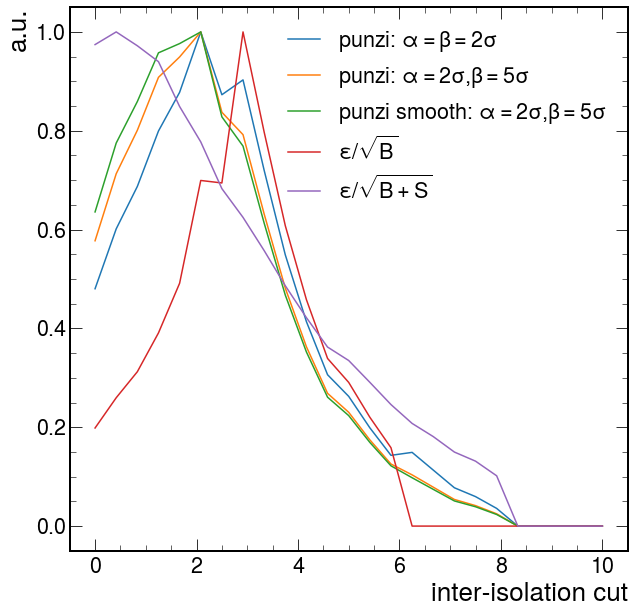

In [157]:
binning = np.linspace(0,10,25)
plt.plot(binning, punzi1/np.max(punzi1), label=r'punzi: $\alpha=\beta=2\sigma$')
plt.plot(binning, punzi2/np.max(punzi2), label=r'punzi: $\alpha=2\sigma$,$\beta=5\sigma$')
plt.plot(binning, punzi3/np.max(punzi3), label=r'punzi smooth: $\alpha=2\sigma$,$\beta=5\sigma$')
plt.plot(binning, SoverB/np.max(SoverB), label=r'$\epsilon/\sqrt{B}$')
plt.plot(binning, SoverBandS/np.max(SoverBandS), label=r'$\epsilon/\sqrt{B+S}$')
plt.xlabel('inter-isolation cut')
plt.ylabel('a.u.')
plt.legend()

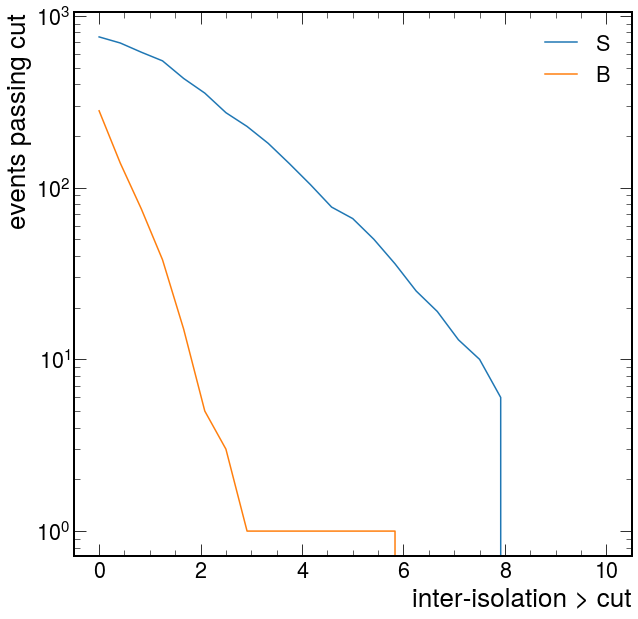

In [158]:
binning = np.linspace(0,10,25)
plt.plot(binning, S, label=r'$S$')
plt.plot(binning, B, label=r'$B$')
plt.xlabel('inter-isolation > cut')
plt.ylabel('events passing cut')
plt.yscale('log')
plt.legend()

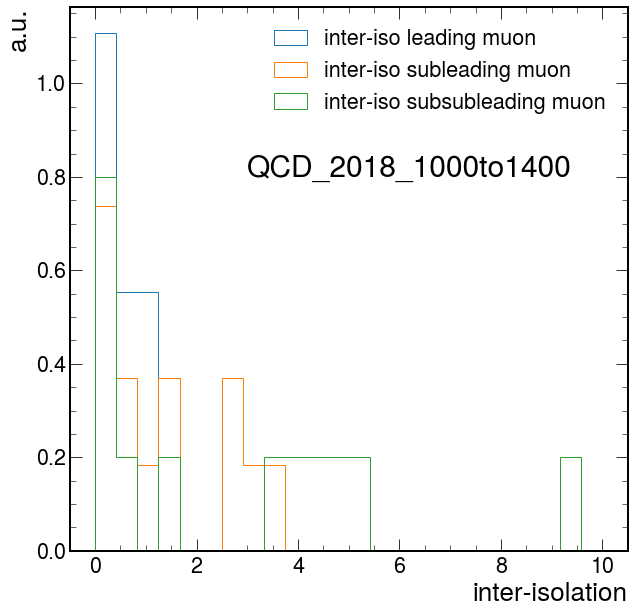

In [12]:
plt.hist(iso_leadingMuon, bins=np.linspace(0,10,25), histtype='step', density=True, label='inter-iso leading muon')
plt.hist(iso_subleadingMuon, bins=np.linspace(0,10,25), histtype='step', density=True, label='inter-iso subleading muon')
plt.hist(iso_subsubleadingMuon, bins=np.linspace(0,10,25), histtype='step', density=True, label='inter-iso subsubleading muon')
plt.text(3,0.8,'QCD_2018_1000to1400',fontsize=30)
plt.xlabel('inter-isolation')
plt.ylabel('a.u.')
#plt.yscale('log')
plt.legend()

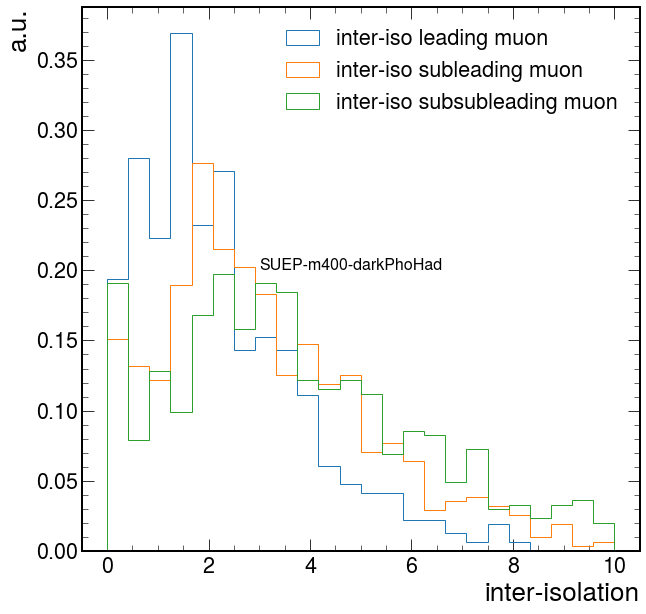

In [45]:
plt.hist(iso_leadingMuon, bins=np.linspace(0,10,25), histtype='step', density=True, label='inter-iso leading muon')
plt.hist(iso_subleadingMuon, bins=np.linspace(0,10,25), histtype='step', density=True, label='inter-iso subleading muon')
plt.hist(iso_subsubleadingMuon, bins=np.linspace(0,10,25), histtype='step', density=True, label='inter-iso subsubleading muon')
plt.text(3,0.2,'SUEP-m400-darkPhoHad',fontsize=16)
#plt.yscale('log')
plt.xlabel('inter-isolation')
plt.ylabel('a.u.')
plt.legend()

In [60]:
idx = [
    [0,0],
    [1,0],
    [0,1],
    [1,1],
]
for i_evt in range(4):
    i=idx[i_evt][0]
    j=idx[i_evt][1]
    print(i, j)

0 0
1 0
0 1
1 1


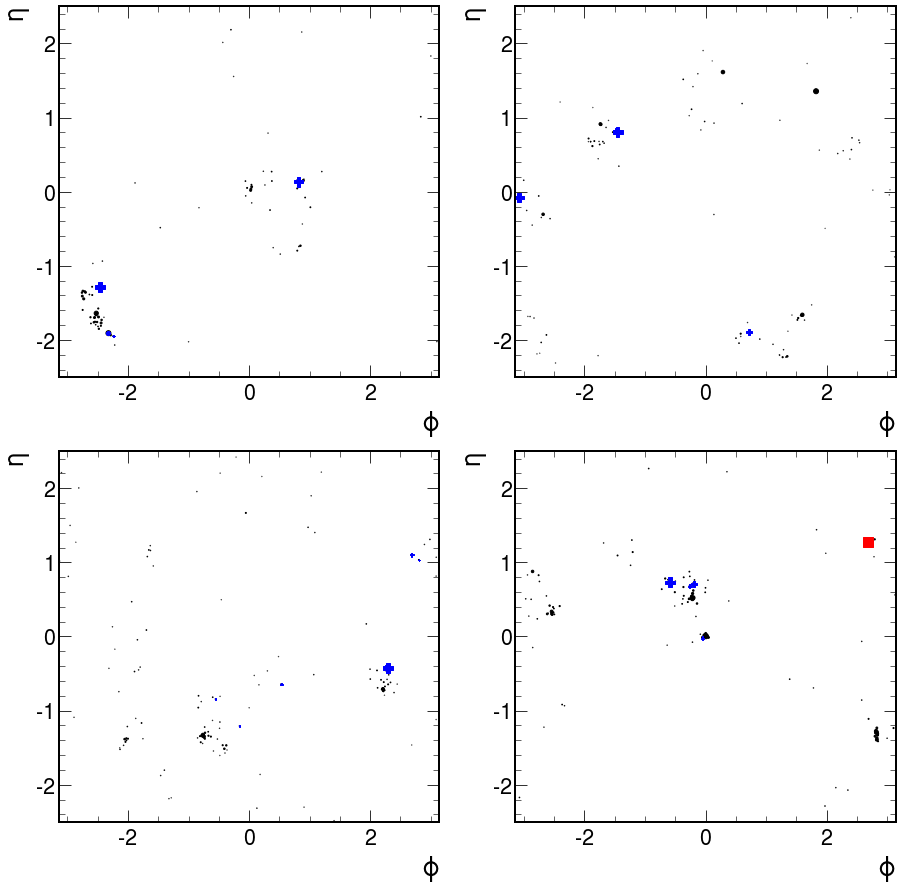

In [24]:
idx = [
    [0,0],
    [1,0],
    [0,1],
    [1,1],
]
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
marker_factor = 100
for i_evt in range(4):
    i=idx[i_evt][0]
    j=idx[i_evt][1]
    ax[i,j].scatter(
        pfcands[i_evt].phi,
        pfcands[i_evt].eta,
        s=marker_factor*pfcands[i_evt].pt/ak.max(pfcands[i_evt].pt),
        color='black',
        marker='.',
    )
    ax[i,j].scatter(
        muons[i_evt].phi,
        muons[i_evt].eta,
        s=marker_factor*muons[i_evt].pt/ak.max(muons[i_evt].pt),
        color='blue',
        marker='P',
    )
    if len(electrons[i_evt]) > 0:
        ax[i,j].scatter(
            electrons[i_evt].phi,
            electrons[i_evt].eta,
            s=marker_factor*electrons[i_evt].pt/ak.max(electrons[i_evt].pt),
            color='red',
            marker='s',
        )
    ax[i,j].axis(xmin=-math.pi,xmax=math.pi)
    ax[i,j].axis(ymin=-2.5, ymax=2.5)
    ax[i,j].set_xlabel(r'$\phi$')
    ax[i,j].set_ylabel(r'$\eta$')
fig.show()